# House Price Prediction Model
Datasets include home variables which contain 79 features in Ames and Lowa. It is kaggle competition. There is two datasets which name's are *train.csv and test.csv* because of kaggle. Should to predict variables for empty **test.csv**. <br>
**Competition Link:** <br>
https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview/evaluation <br>
**Business Problem** <br>
Company wants to make efficient model to home price prediction with using by datasets. <br>
It can be look *datasets/data_description.txt* file for understanding data.
## Configuration / Building Spark

In [1]:
from pyspark.sql import SparkSession, functions as F
import findspark

In [2]:
findspark.init("C:\Program Files\Spark\spark-3.3.1-bin-hadoop3")

In [3]:
spark = SparkSession.builder \
    .appName("House Price Model") \
    .master("local[4]") \
    .config("spark.sql.shuffle.partitions", "5") \
    .config("spark.sql.adaptive.enabled", True) \
    .getOrCreate()

## Exploratory Data Analysis
### Handling Dataset

In [4]:
path = "file:///Users/talha/OneDrive/Masaüstü/Talha Nebi Kumru/Data Science/Miuul/Machine Learning/House_Price_Prediction/datasets/train.csv"
train = spark.read \
    .format("csv") \
    .option("inferSchema", True) \
    .option("header", True) \
    .load(path)

In [5]:
path = "file:///Users/talha/OneDrive/Masaüstü/Talha Nebi Kumru/Data Science/Miuul/Machine Learning/House_Price_Prediction/datasets/test.csv"
test = spark.read \
    .format("csv") \
    .option("inferSchema", True) \
    .option("header", True) \
    .load(path)

In [6]:
train.limit(5).toPandas()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NA,NA,NA,0,12,2008,WD,Normal,250000


In [7]:
test.limit(5).toPandas()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80,11622,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,CBlock,TA,TA,No,Rec,468,LwQ,144,270,882,GasA,TA,Y,SBrkr,896,0,0,896,0,0,1,0,2,1,TA,5,Typ,0,NA,Attchd,1961,Unf,1,730,TA,TA,Y,140,0,0,0,120,0,NA,MnPrv,NA,0,6,2010,WD,Normal
1,1462,20,RL,81,14267,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108,TA,TA,CBlock,TA,TA,No,ALQ,923,Unf,0,406,1329,GasA,TA,Y,SBrkr,1329,0,0,1329,0,0,1,1,3,1,Gd,6,Typ,0,NA,Attchd,1958,Unf,1,312,TA,TA,Y,393,36,0,0,0,0,NA,NA,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74,13830,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,PConc,Gd,TA,No,GLQ,791,Unf,0,137,928,GasA,Gd,Y,SBrkr,928,701,0,1629,0,0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997,Fin,2,482,TA,TA,Y,212,34,0,0,0,0,NA,MnPrv,NA,0,3,2010,WD,Normal
3,1464,60,RL,78,9978,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20,TA,TA,PConc,TA,TA,No,GLQ,602,Unf,0,324,926,GasA,Ex,Y,SBrkr,926,678,0,1604,0,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998,Fin,2,470,TA,TA,Y,360,36,0,0,0,0,NA,NA,NA,0,6,2010,WD,Normal
4,1465,120,RL,43,5005,Pave,NA,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0,Gd,TA,PConc,Gd,TA,No,ALQ,263,Unf,0,1017,1280,GasA,Ex,Y,SBrkr,1280,0,0,1280,0,0,2,0,2,1,Gd,5,Typ,0,NA,Attchd,1992,RFn,2,506,TA,TA,Y,0,82,0,0,144,0,NA,NA,NA,0,1,2010,WD,Normal


In [8]:
train.dtypes == test.dtypes

False

Train dataset and Test dataset were read different variable type each other. There can be problem for future operations. It can be better to merge two datasets. Have to create *SalePrice* column to test dataset.

In [9]:
test = test.withColumn('SalesPrice', F.lit(None))

In [10]:
df = train.union(test)

In [11]:
df.count() == train.count() + test.count()

True

Success for merging two dataframes to each other.

In [12]:
df.toPandas().head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NA,NA,NA,0,12,2008,WD,Normal,250000.0


In [13]:
df.toPandas().tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2914,2915,160,RM,21,1936,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,546,546,GasA,...,Y,SBrkr,546,546,0,1092,0,0,1,1,3,1,TA,5,Typ,0,NA,NA,NA,NA,0,0,NA,NA,Y,0,0,0,0,0,0,NA,NA,NA,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21,1894,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0,TA,TA,CBlock,TA,TA,No,Rec,252,Unf,0,294,546,GasA,...,Y,SBrkr,546,546,0,1092,0,0,1,1,3,1,TA,6,Typ,0,NA,CarPort,1970,Unf,1,286,TA,TA,Y,0,24,0,0,0,0,NA,NA,NA,0,4,2006,WD,Abnorml,NaN
2916,2917,20,RL,160,20000,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,CBlock,TA,TA,No,ALQ,1224,Unf,0,0,1224,GasA,...,Y,SBrkr,1224,0,0,1224,1,0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960,Unf,2,576,TA,TA,Y,474,0,0,0,0,0,NA,NA,NA,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62,10441,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0,TA,TA,PConc,Gd,TA,Av,GLQ,337,Unf,0,575,912,GasA,...,Y,SBrkr,970,0,0,970,0,1,1,0,3,1,TA,6,Typ,0,NA,NA,NA,NA,0,0,NA,NA,Y,80,32,0,0,0,0,NA,MnPrv,Shed,700,7,2006,WD,Normal,NaN
2918,2919,60,RL,74,9627,Pave,NA,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,2Story,7,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,BrkFace,94,TA,TA,PConc,Gd,TA,Av,LwQ,758,Unf,0,238,996,GasA,...,Y,SBrkr,996,1004,0,2000,0,0,2,1,3,1,TA,9,Typ,1,TA,Attchd,1993,Fin,3,650,TA,TA,Y,190,48,0,0,0,0,NA,NA,NA,0,11,2006,WD,Normal,NaN


### Seperate Columns for Variables Types

In [14]:
from _eda_utils import seperate_columns

In [15]:
num_cols, cat_cols = seperate_columns(spark, df.dtypes)

2023-04-06 05:50:03,690 - logging_utils - DEBUG - seperate_columns function executing...
2023-04-06 05:50:03,691 - logging_utils - INFO - 
Numerical Columns: ['MSSubClass', 'EnclosedPorch', 'GrLivArea', 'PoolArea', 'OverallQual', 'FullBath', 'LotArea', 'MoSold', 'YearBuilt', 'OpenPorchSF', '1stFlrSF', 'OverallCond', '2ndFlrSF', 'LowQualFinSF', 'TotRmsAbvGrd', 'YearRemodAdd', 'WoodDeckSF', 'Fireplaces', 'BedroomAbvGr', 'MiscVal', 'Id', 'HalfBath', 'YrSold', 'KitchenAbvGr', '3SsnPorch', 'ScreenPorch', 'SalePrice']
2023-04-06 05:50:03,692 - logging_utils - INFO - 
Categorical Columns: ['MSZoning', 'LotFrontage', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'Bsmt

#### Controlling Column Types

In [16]:
df.select(cat_cols).orderBy(F.rand()).limit(10).toPandas()

,MSZoning,LotFrontage,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,BsmtFullBath,BsmtHalfBath,KitchenQual,Functional,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,70,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,Wd Sdng,Wd Sdng,None,0,TA,TA,CBlock,TA,TA,No,Rec,612,Unf,0,252,864,GasA,Ex,Y,SBrkr,0,0,TA,Typ,NA,Detchd,2008,Unf,1,300,Ex,Ex,Y,NA,NA,Shed,WD,Normal
1,RL,75,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,Hip,CompShg,VinylSd,VinylSd,BrkFace,281,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1777,1777,GasA,Ex,Y,SBrkr,0,0,Gd,Typ,Gd,Attchd,2002,RFn,2,534,TA,TA,Y,NA,NA,NA,WD,Normal
2,RL,65,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,RRAe,Norm,2fmCon,1Story,Gable,CompShg,HdBoard,HdBoard,None,0,TA,TA,CBlock,TA,Fa,Mn,ALQ,890,Unf,0,0,890,GasA,Gd,N,SBrkr,1,0,TA,Typ,NA,Detchd,1970,Unf,1,308,TA,TA,Y,NA,NA,NA,WD,Normal
3,RM,81,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,Gable,CompShg,WdShing,Wd Shng,None,0,Fa,Fa,BrkTil,TA,TA,No,Rec,360,Unf,0,576,936,GasA,Gd,N,FuseA,0,0,Ex,Typ,Gd,Detchd,1920,Unf,1,225,Fa,Fa,N,NA,NA,NA,WD,Normal
4,FV,72,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,0,Gd,TA,PConc,Gd,TA,No,GLQ,24,Unf,0,1254,1278,GasA,Ex,Y,SBrkr,0,0,Gd,Typ,NA,Attchd,2006,RFn,2,584,TA,TA,Y,NA,NA,NA,New,Partial
5,RL,64,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1330,1330,GasA,Ex,Y,SBrkr,0,0,Gd,Typ,Gd,Attchd,2006,Fin,2,437,TA,TA,Y,NA,NA,NA,New,Partial
6,RL,72,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,2Story,Hip,CompShg,Plywood,Plywood,None,0,TA,TA,CBlock,TA,TA,Av,ALQ,288,Unf,0,396,684,GasA,TA,Y,SBrkr,0,0,TA,Typ,TA,Attchd,1976,Fin,2,440,TA,TA,Y,NA,MnPrv,NA,WD,Normal
7,RL,85,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,SLvl,Hip,CompShg,HdBoard,HdBoard,BrkFace,90,TA,TA,CBlock,TA,TA,Gd,ALQ,568,Unf,0,640,1208,GasA,Ex,Y,SBrkr,1,0,Gd,Typ,Po,BuiltIn,1961,Fin,2,368,TA,TA,Y,NA,NA,NA,WD,Normal
8,RL,NA,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,396,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1055,1055,GasA,Ex,Y,SBrkr,0,0,Gd,Typ,TA,BuiltIn,2001,Fin,2,905,TA,TA,Y,NA,NA,NA,WD,Normal
9,RL,75,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,Gable,CompShg,HdBoard,HdBoard,None,0,Gd,TA,CBlock,TA,TA,No,BLQ,830,LwQ,290,136,1256,GasA,Gd,Y,SBrkr,1,0,TA,Typ,NA,Attchd,1965,Fin,1,276,TA,TA,Y,NA,NA,NA,WD,Normal


On the above, It can look the categorical columns but as we seen these columns cannot be categorical:

In [17]:
failed_cat_cols = ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
                   'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
                   'GarageCars', 'GarageArea', 'GarageYrBlt']

In [18]:
for col in failed_cat_cols:
    df = df.withColumn(col, F.col(col).cast("int")) 

In [19]:
df.select(failed_cat_cols).dtypes

[('LotFrontage', 'int'),
 ('MasVnrArea', 'int'),
 ('BsmtFinSF1', 'int'),
 ('BsmtFinSF2', 'int'),
 ('BsmtUnfSF', 'int'),
 ('TotalBsmtSF', 'int'),
 ('BsmtFullBath', 'int'),
 ('BsmtHalfBath', 'int'),
 ('GarageCars', 'int'),
 ('GarageArea', 'int'),
 ('GarageYrBlt', 'int')]

In [20]:
num_cols += failed_cat_cols

In [21]:
cat_cols = [col for col in cat_cols if not col in failed_cat_cols]

In [22]:
df.select(cat_cols).orderBy(F.rand()).limit(10).toPandas()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RM,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Blueste,Norm,Norm,TwnhsE,2Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,No,ALQ,Unf,GasA,TA,Y,SBrkr,TA,Typ,TA,Attchd,Fin,TA,TA,Y,NA,GdPrv,NA,WD,Normal
1,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,Wd Sdng,Wd Sdng,None,TA,TA,CBlock,TA,TA,No,LwQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,Unf,TA,TA,Y,NA,NA,NA,WD,Normal
2,RL,Pave,NA,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,Gable,CompShg,CemntBd,CmentBd,None,Gd,TA,PConc,Gd,TA,Gd,GLQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
3,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,HdBoard,HdBoard,BrkFace,TA,TA,CBlock,Gd,TA,No,Unf,Unf,GasA,TA,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NA,MnPrv,NA,WD,Family
4,RM,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,Norm,TwnhsE,2Story,Gable,CompShg,HdBoard,HdBoard,BrkFace,TA,TA,CBlock,TA,TA,No,LwQ,Unf,GasA,Gd,Y,SBrkr,Gd,Min1,Fa,Attchd,Unf,TA,TA,Y,NA,NA,NA,WD,Normal
5,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,Gable,CompShg,CemntBd,CmentBd,Stone,Gd,TA,PConc,Gd,TA,Av,Unf,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NA,Attchd,Fin,TA,TA,Y,NA,NA,NA,New,Partial
6,RL,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,NWAmes,Norm,Norm,1Fam,2Story,Gable,CompShg,HdBoard,HdBoard,BrkFace,TA,TA,CBlock,TA,TA,No,Rec,Unf,GasA,Gd,Y,SBrkr,TA,Typ,Gd,Attchd,RFn,TA,TA,Y,NA,GdWo,NA,WD,Normal
7,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,Gable,CompShg,HdBoard,HdBoard,BrkFace,TA,TA,CBlock,TA,TA,Av,Rec,BLQ,GasA,TA,Y,SBrkr,TA,Typ,NA,Attchd,RFn,TA,TA,Y,NA,MnPrv,NA,WD,Normal
8,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,BrkFace,TA,Gd,CBlock,TA,TA,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Attchd,Unf,TA,TA,Y,NA,GdWo,NA,WD,Normal
9,RL,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,Gd,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Gd,Y,SBrkr,TA,Typ,NA,Attchd,RFn,TA,TA,Y,NA,NA,NA,New,Partial


In [23]:
df.select(num_cols).orderBy(F.rand()).limit(10).toPandas()

,MSSubClass,EnclosedPorch,GrLivArea,PoolArea,OverallQual,FullBath,LotArea,MoSold,YearBuilt,OpenPorchSF,1stFlrSF,OverallCond,2ndFlrSF,LowQualFinSF,TotRmsAbvGrd,YearRemodAdd,WoodDeckSF,Fireplaces,BedroomAbvGr,MiscVal,Id,HalfBath,YrSold,KitchenAbvGr,3SsnPorch,ScreenPorch,SalePrice,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageCars,GarageArea,GarageYrBlt
0,120,0,1488,0,7,2,4835,3,2004,50,1488,5,0,0,6,2005,168,1,2,0,1496,0,2010,1,0,0,NaN,25,0.0,1298,0,190,1488,1,0,2,506,2004
1,60,0,1880,0,8,2,12217,12,2007,127,955,5,925,0,8,2007,168,1,3,0,2350,1,2007,1,0,0,NaN,112,NaN,745,0,210,955,1,0,3,880,2007
2,20,0,1392,0,5,2,10000,12,2002,49,1392,5,0,0,6,2002,168,1,3,0,2585,0,2007,1,0,0,NaN,80,166.0,585,0,856,1441,0,0,3,650,2002
3,20,0,1779,0,5,1,17920,7,1955,418,1779,4,0,0,6,1974,0,1,3,0,855,1,2006,1,0,312,170000.0,102,0.0,306,1085,372,1763,1,0,2,454,1955
4,85,0,768,0,5,1,8445,3,1972,0,768,7,0,0,5,2007,58,0,2,0,1407,0,2009,1,0,0,133000.0,70,0.0,656,0,112,768,1,0,2,396,1988
5,60,0,1682,0,6,2,8750,6,1998,77,804,5,878,0,7,1998,0,0,3,0,872,1,2010,1,0,0,200500.0,70,116.0,505,0,299,804,0,0,2,523,1998
6,60,0,2172,0,7,2,14154,8,2006,62,1071,5,1101,0,9,2006,192,1,3,0,409,1,2007,1,0,0,280000.0,109,350.0,0,0,1063,1063,0,0,3,947,2006
7,80,0,1265,0,5,2,9350,10,1965,92,1265,8,0,0,6,1999,0,1,3,0,1157,0,2008,1,96,0,179900.0,85,0.0,633,0,586,1219,0,1,2,502,1965
8,20,0,1656,0,6,1,31770,5,1960,62,1656,5,0,0,7,1960,210,2,3,0,172,0,2010,1,0,0,215000.0,141,112.0,639,0,441,1080,1,0,2,528,1960
9,60,0,2157,0,7,2,14200,5,1966,66,1216,6,941,0,8,1966,105,2,4,0,131,1,2006,1,0,0,226000.0,88,309.0,445,0,479,924,0,0,2,487,1966


### Description of Categorical/Numerical Columns

#### Numerical Columns

In [24]:
from _eda_utils import describe_numerical_columns

2023-04-06 05:50:05,971 - logging_utils - DEBUG - describe_numerical_columns function is executing...
2023-04-06 05:50:06,199 - logging_utils - DEBUG - describe_numeric executing...


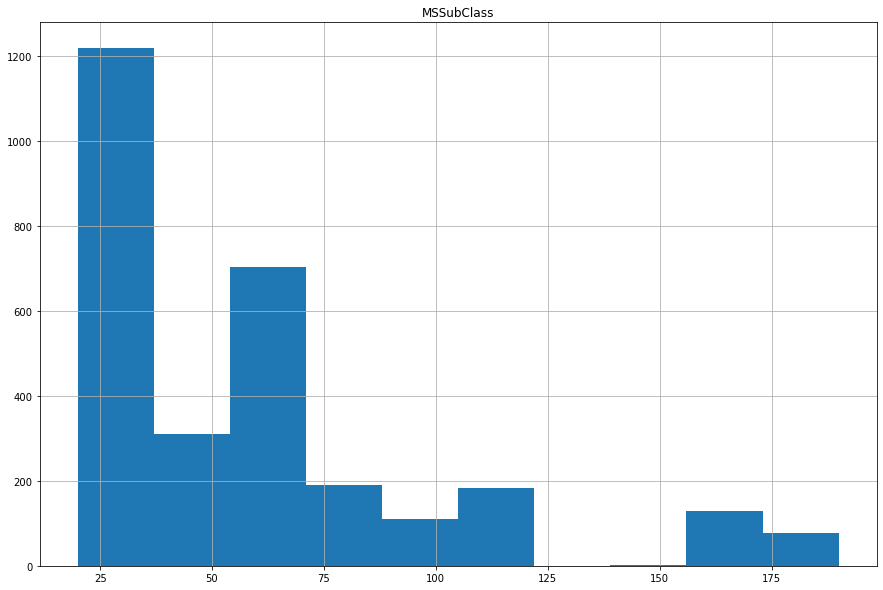

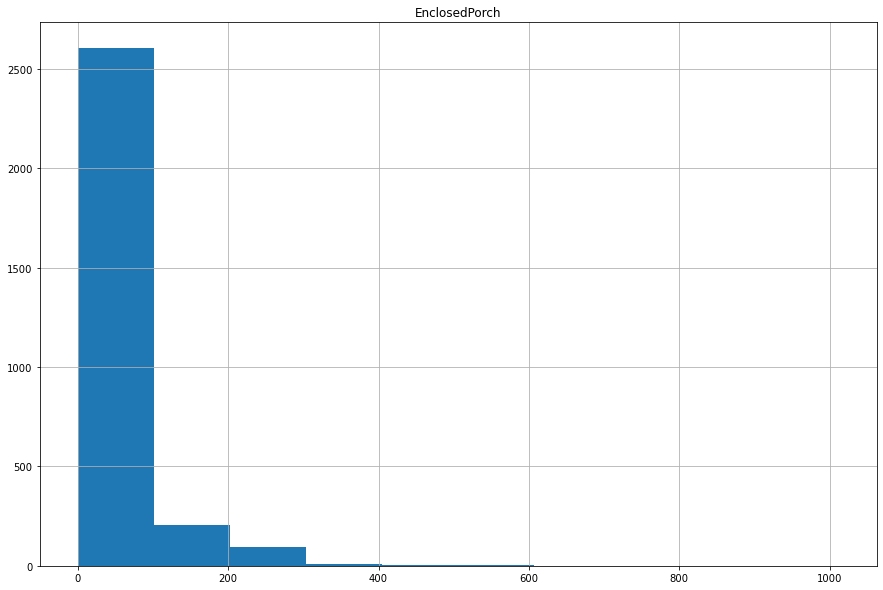

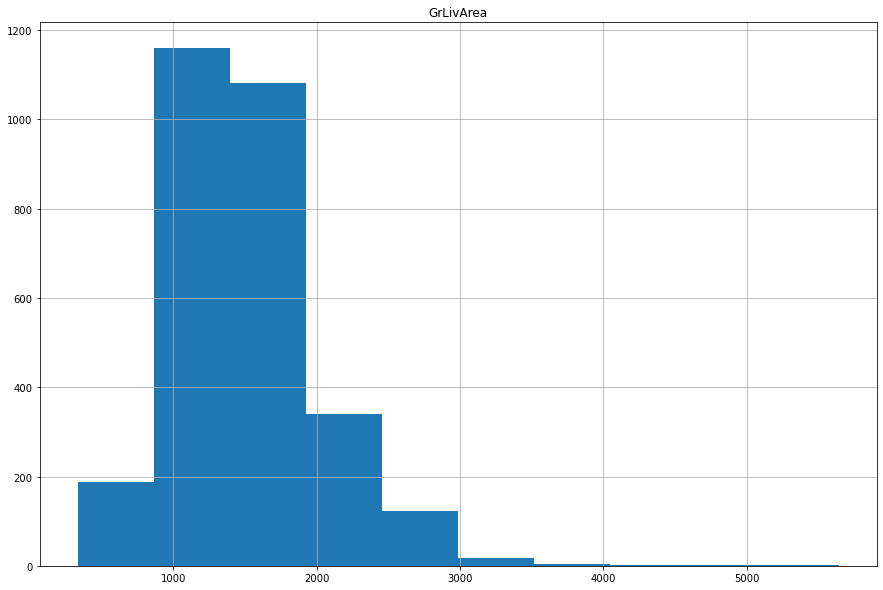

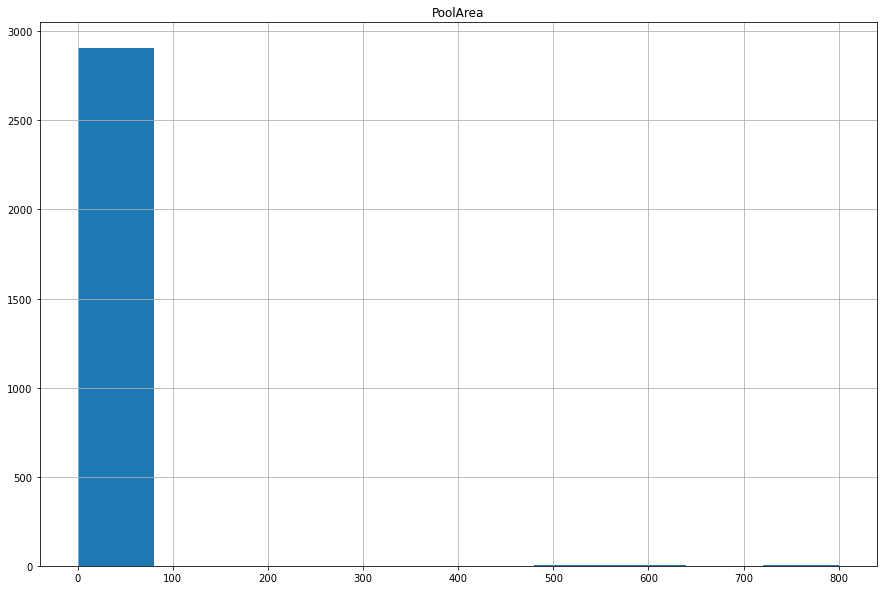

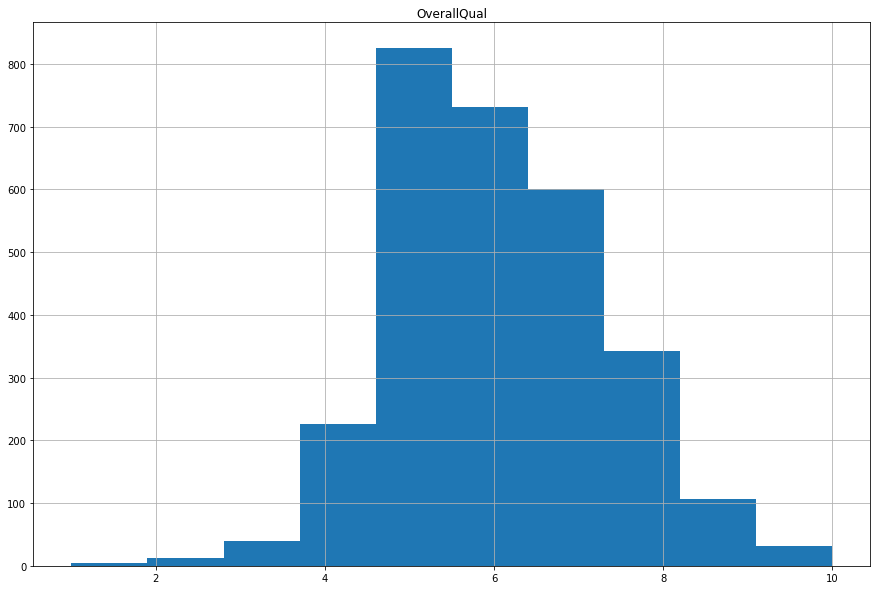

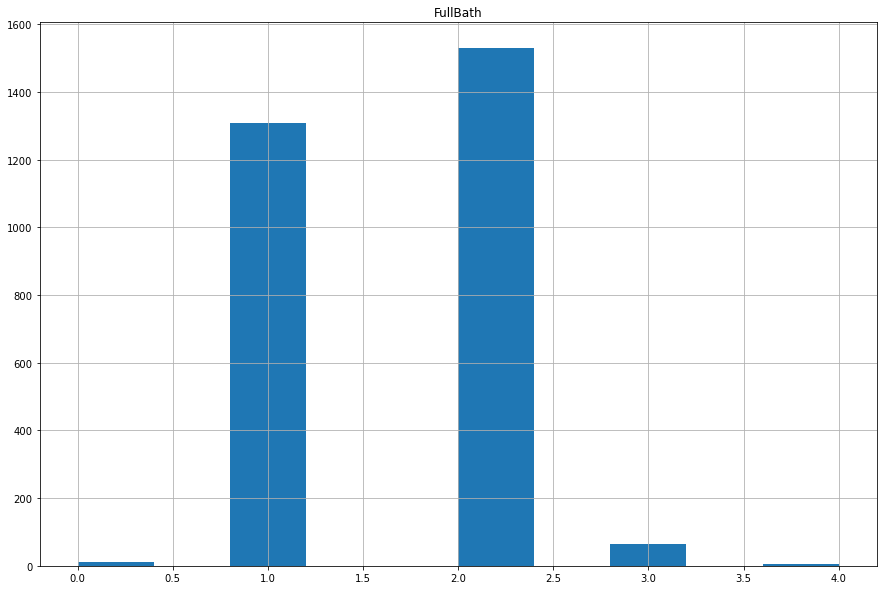

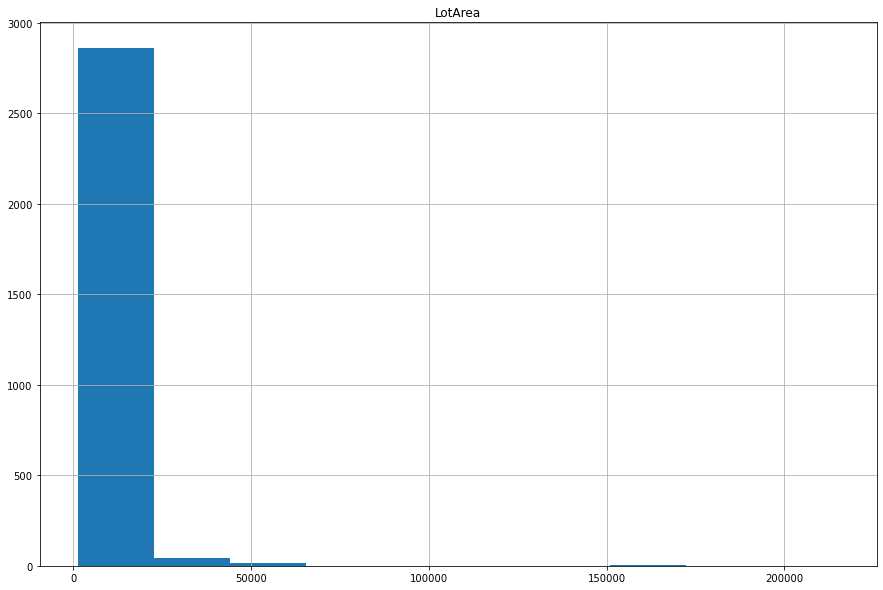

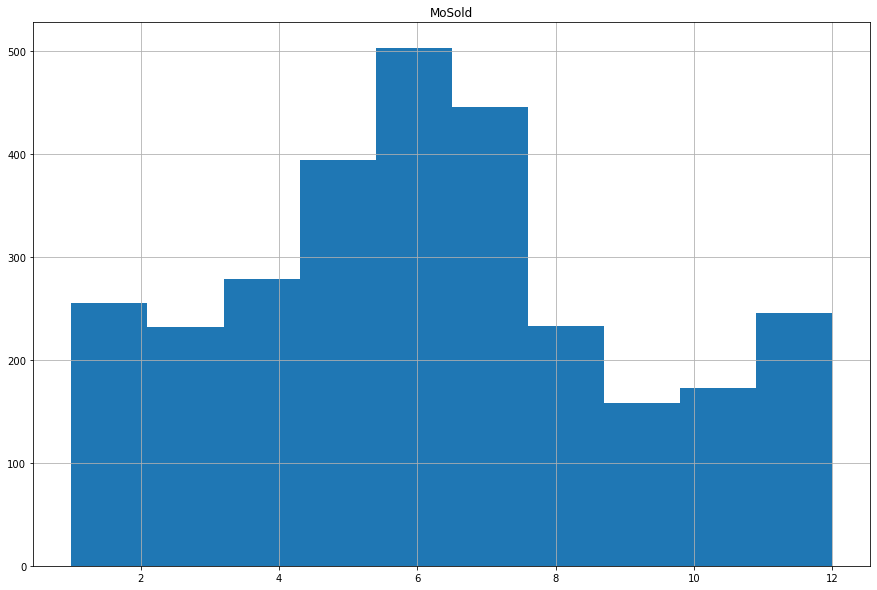

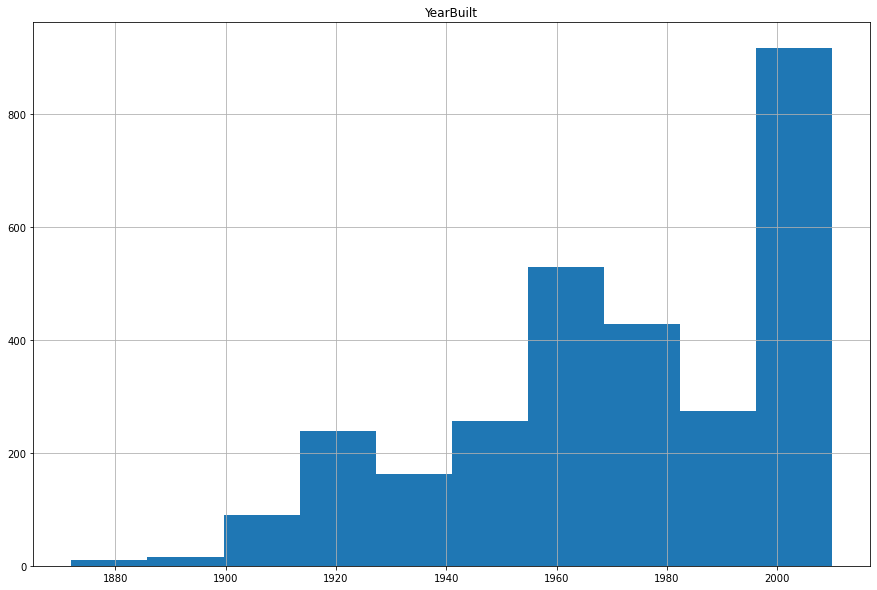

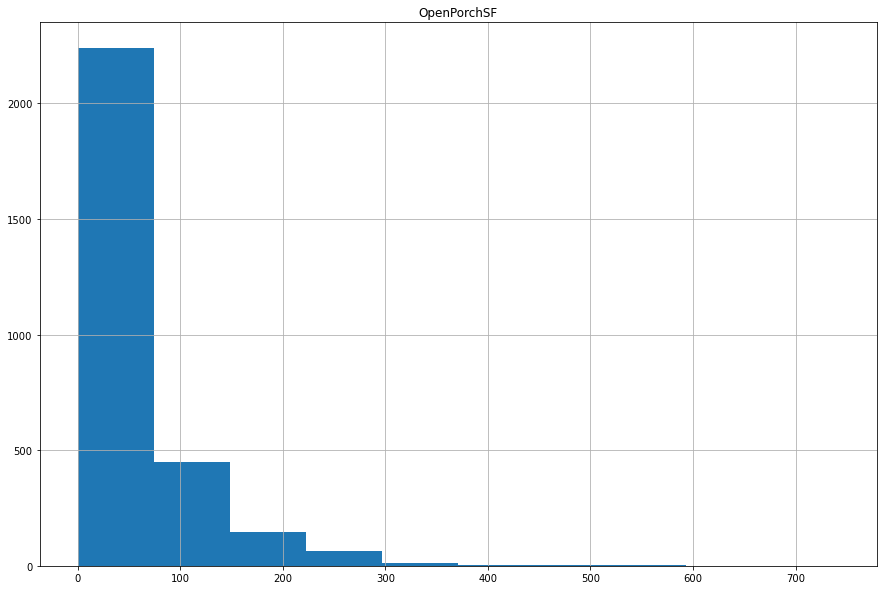

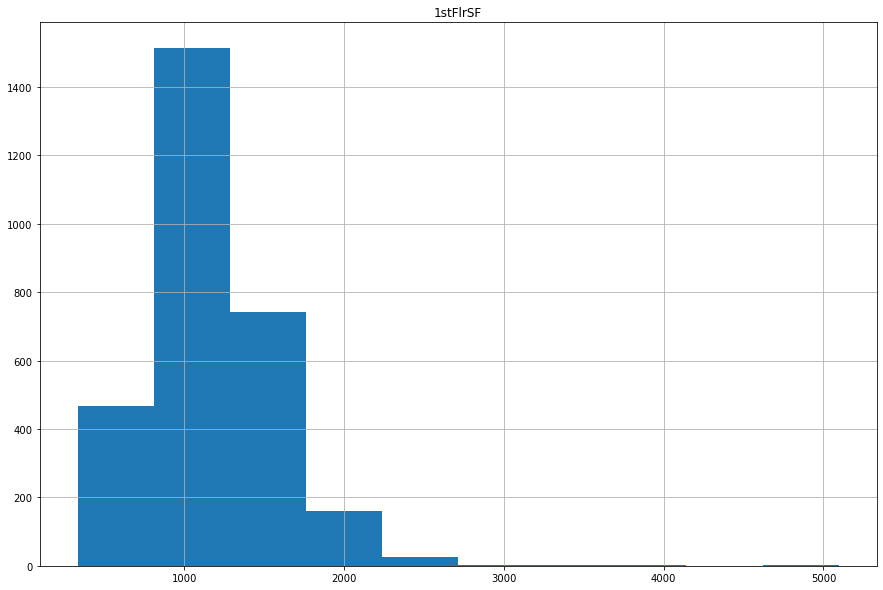

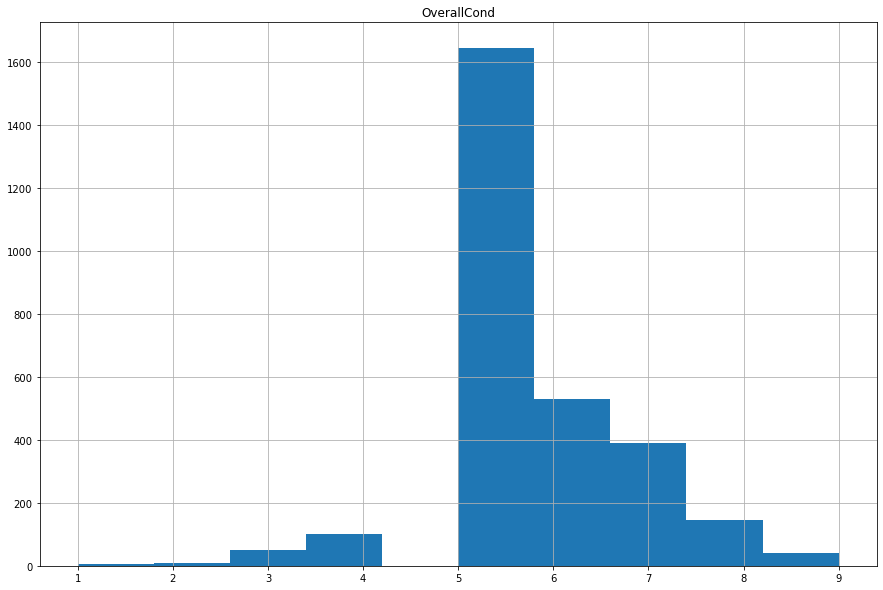

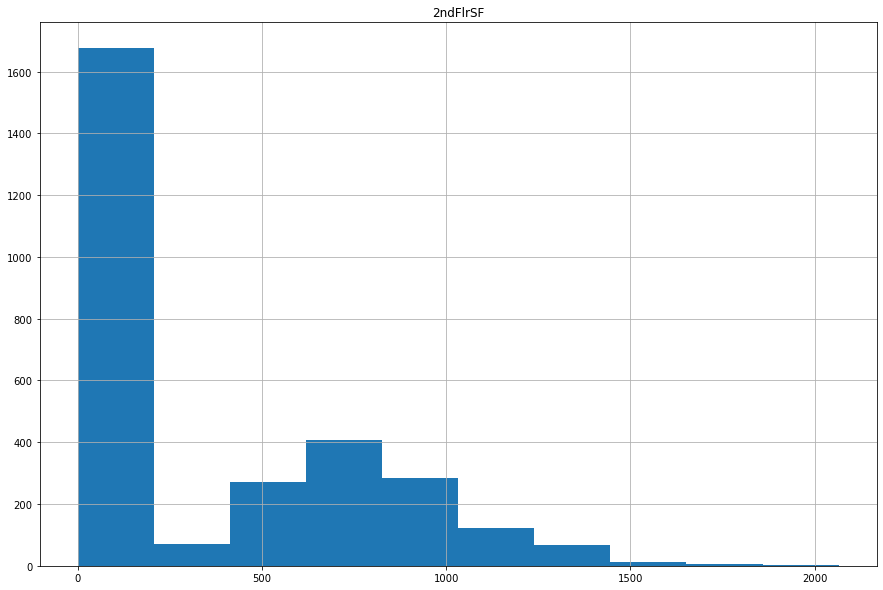

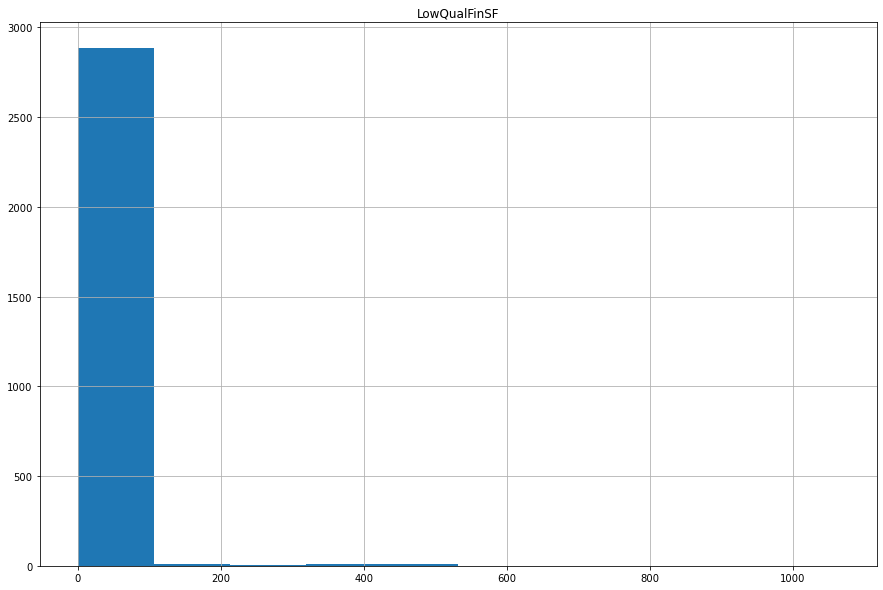

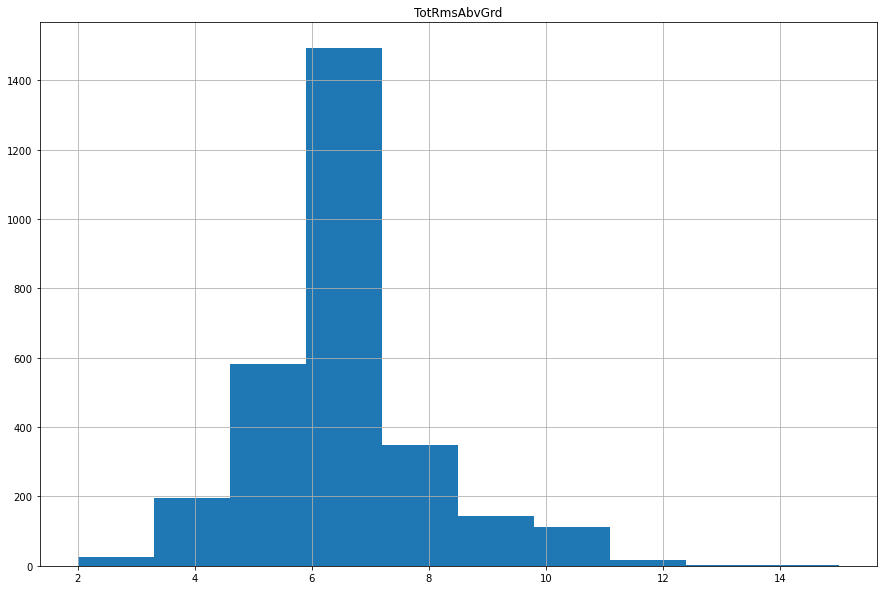

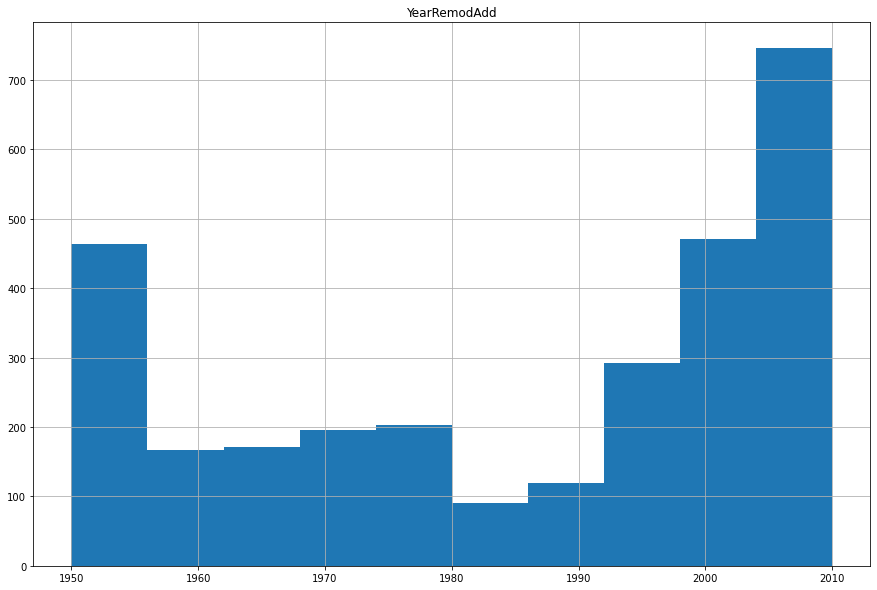

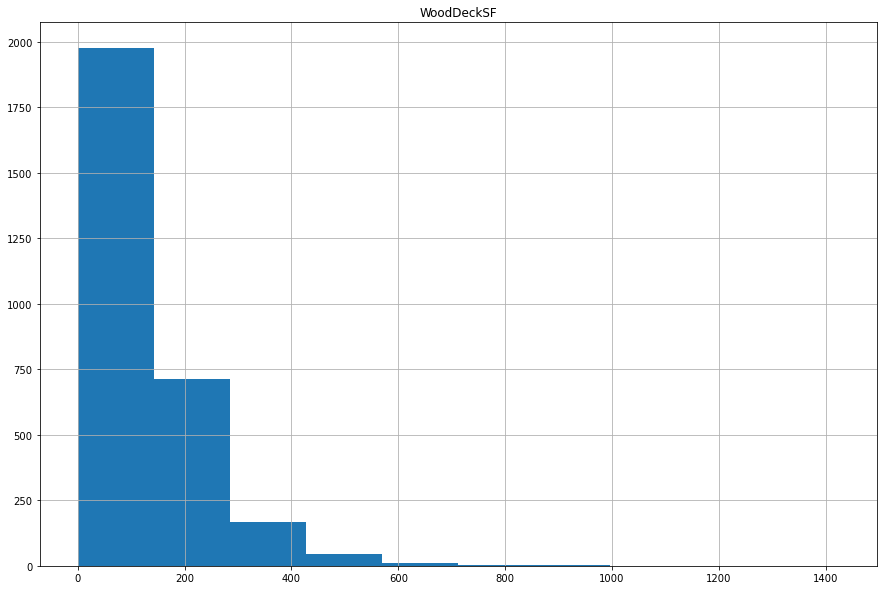

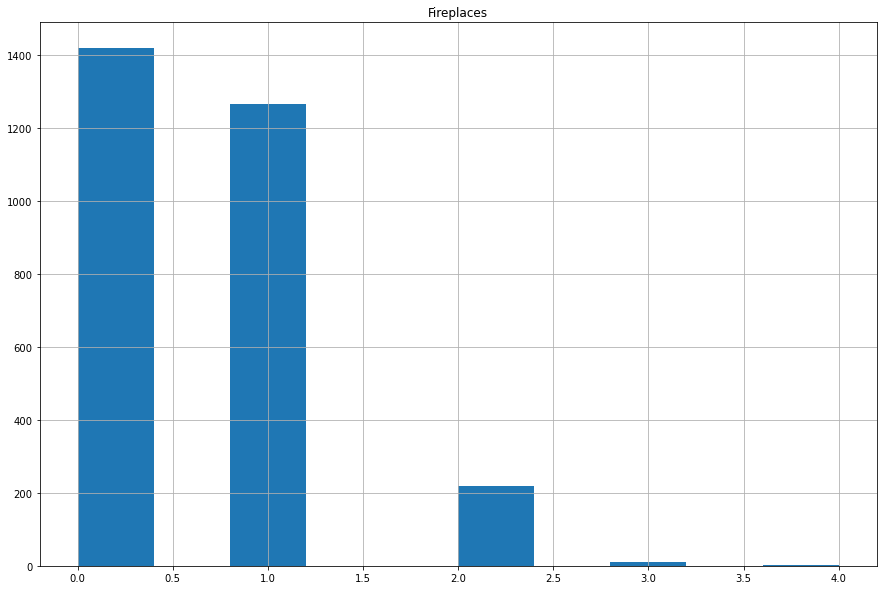

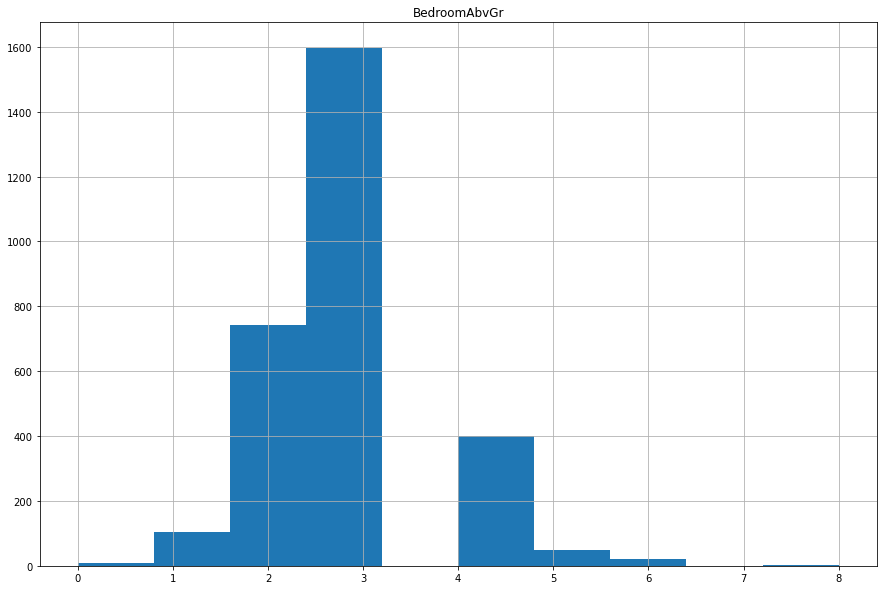

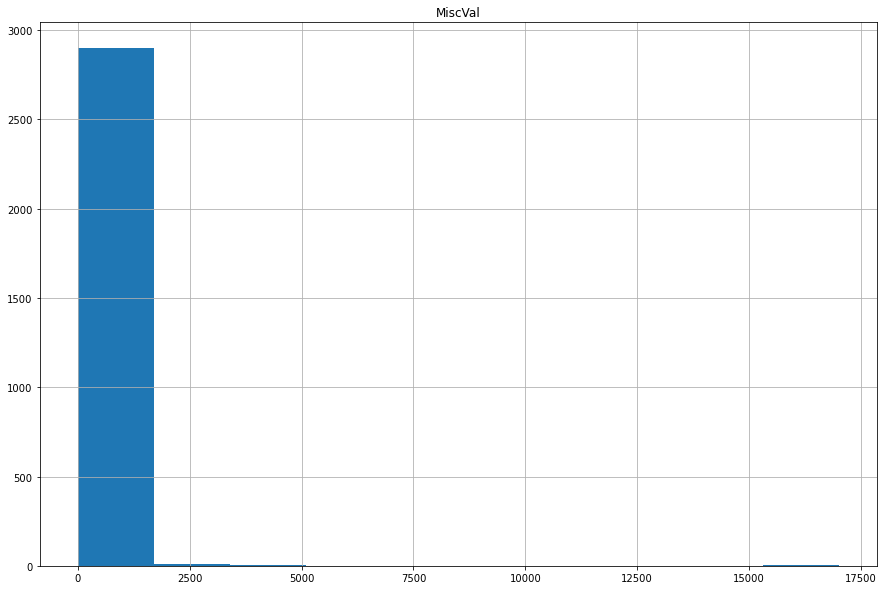

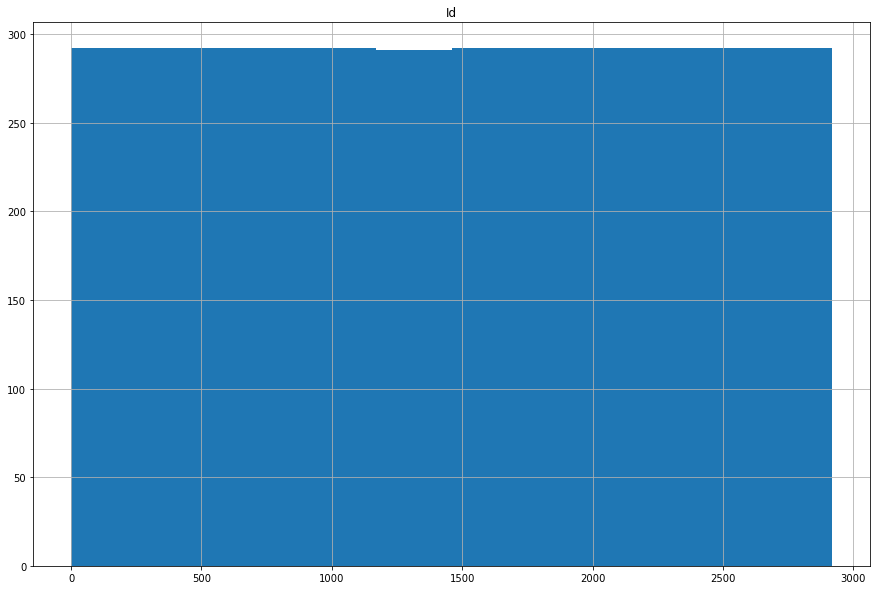

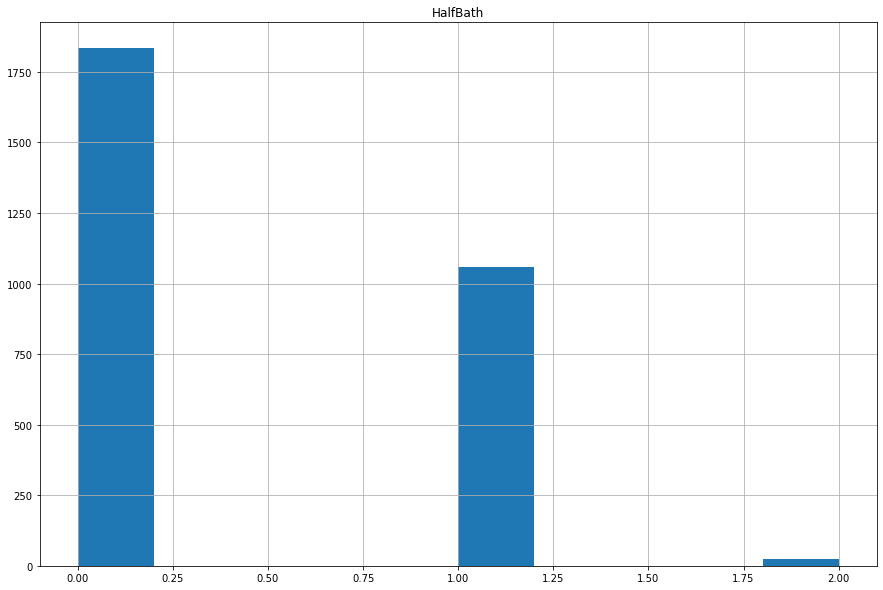

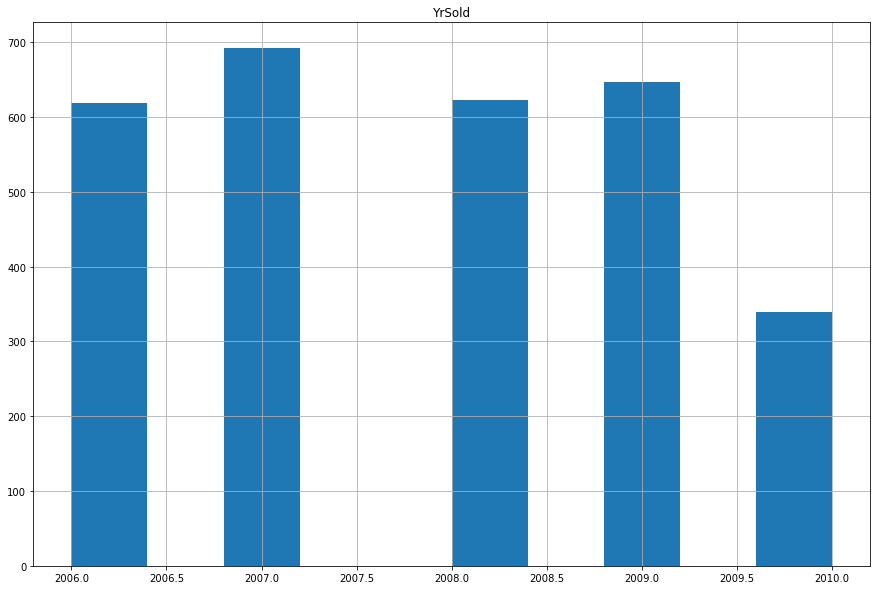

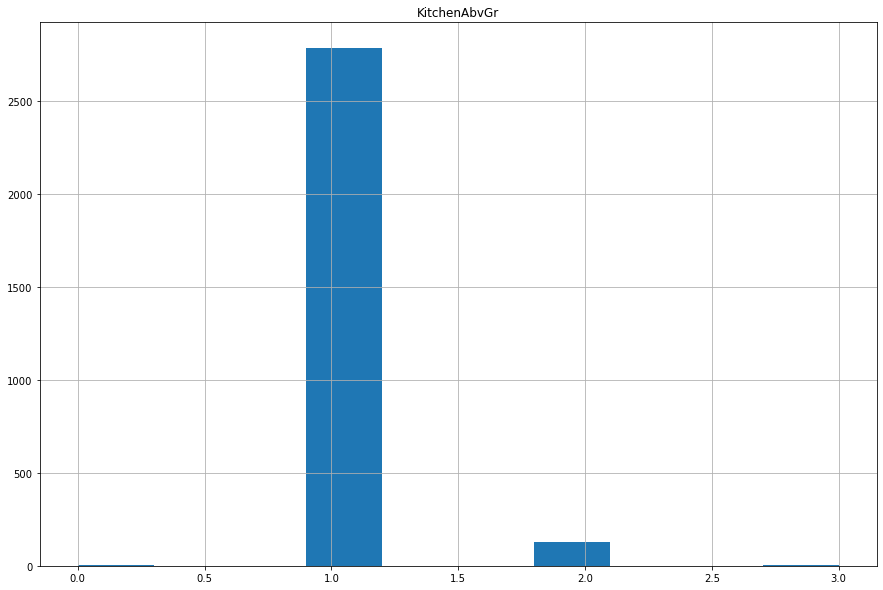

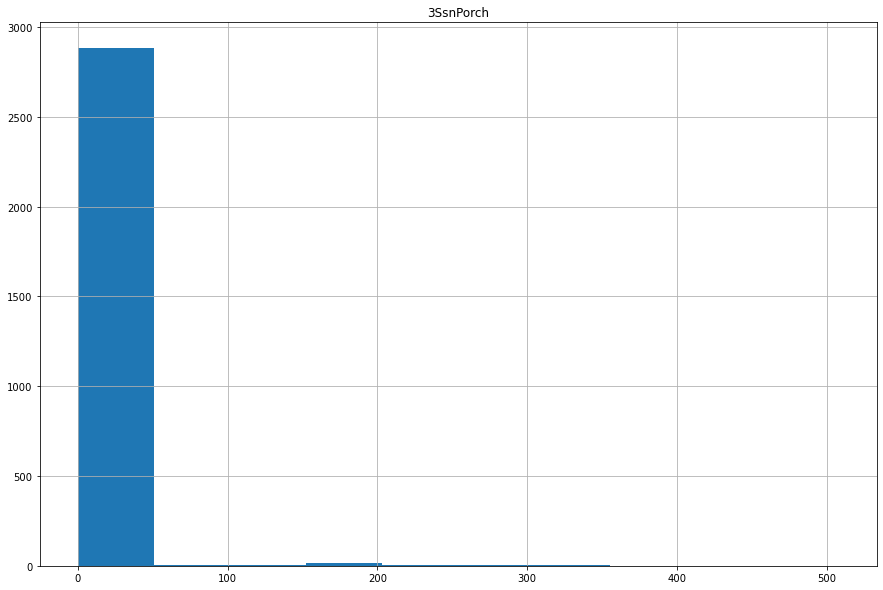

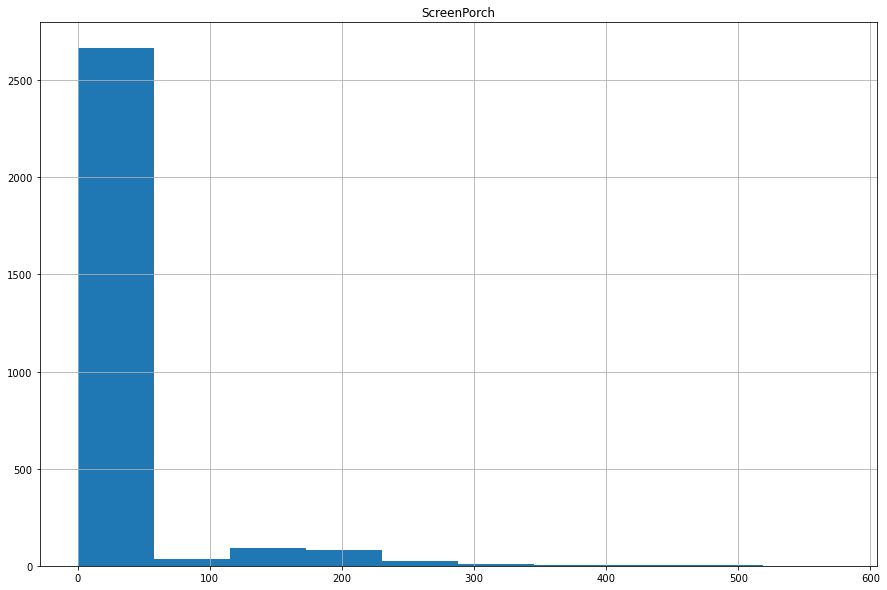

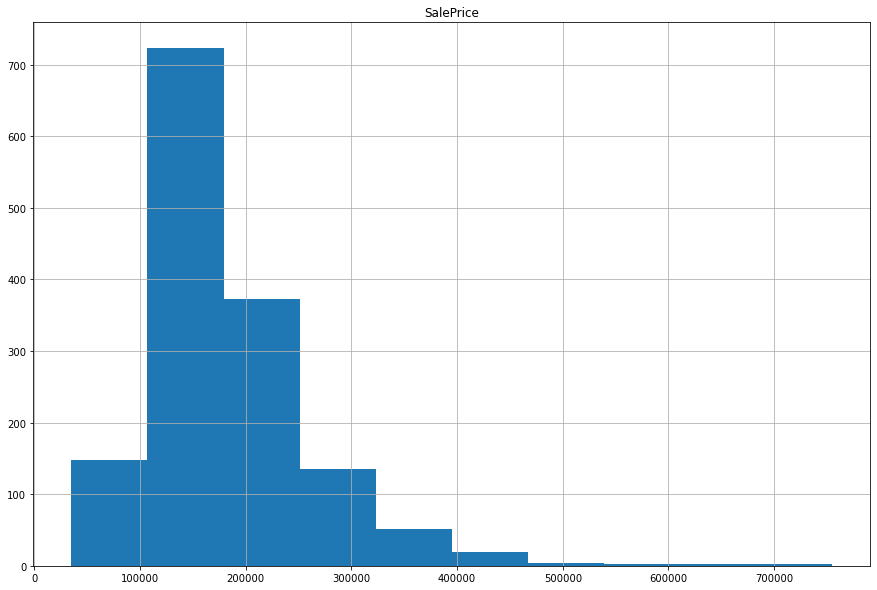

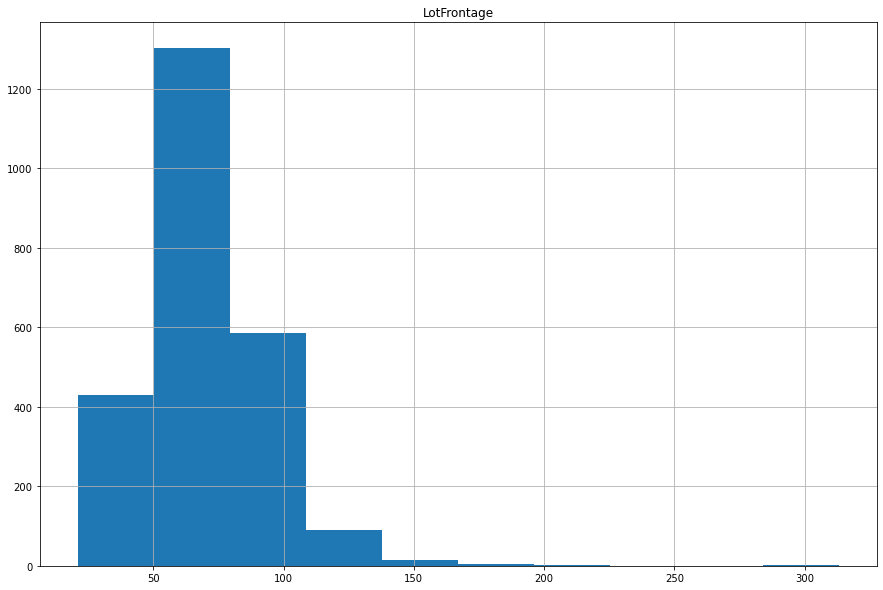

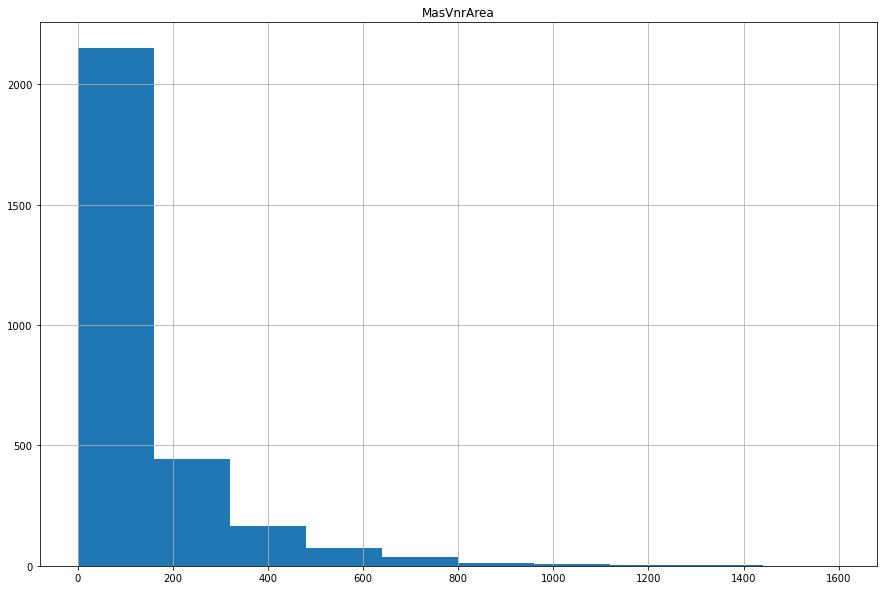

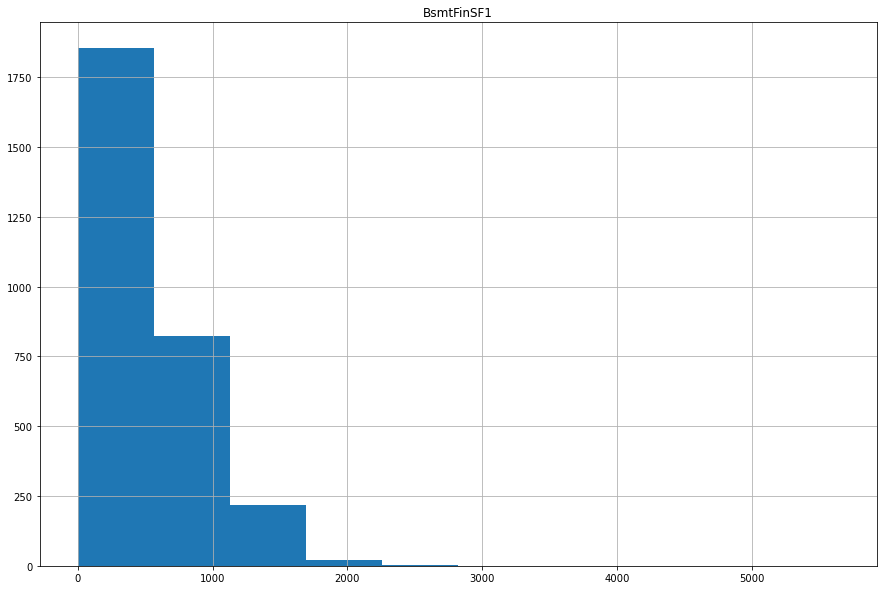

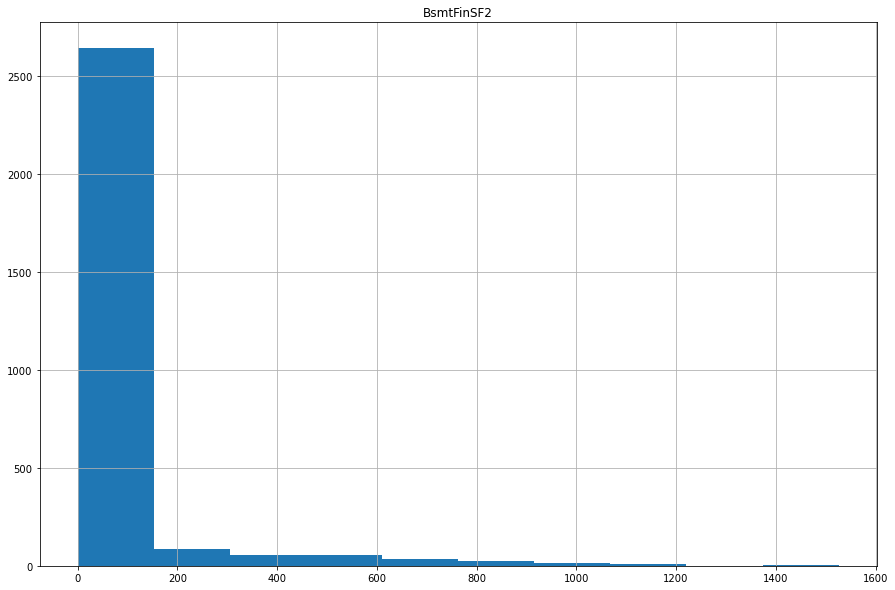

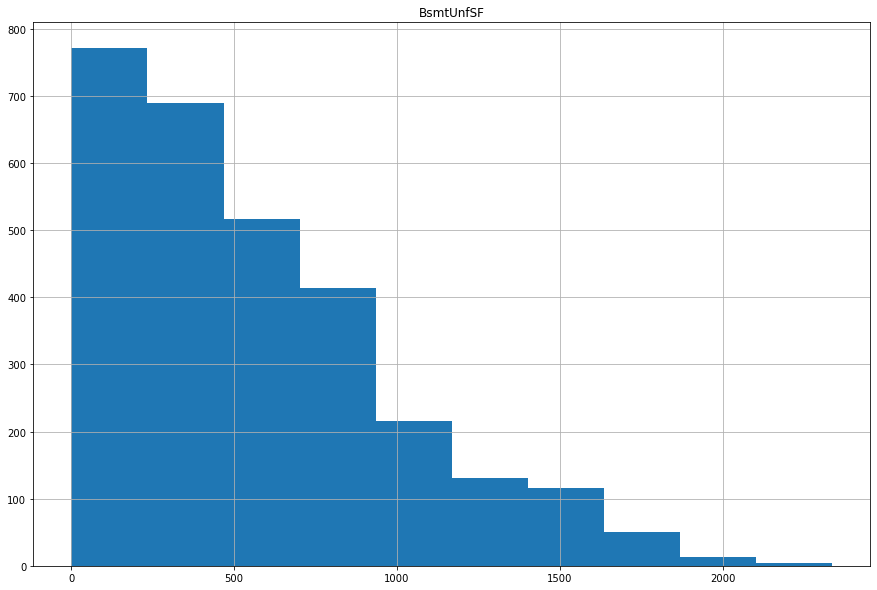

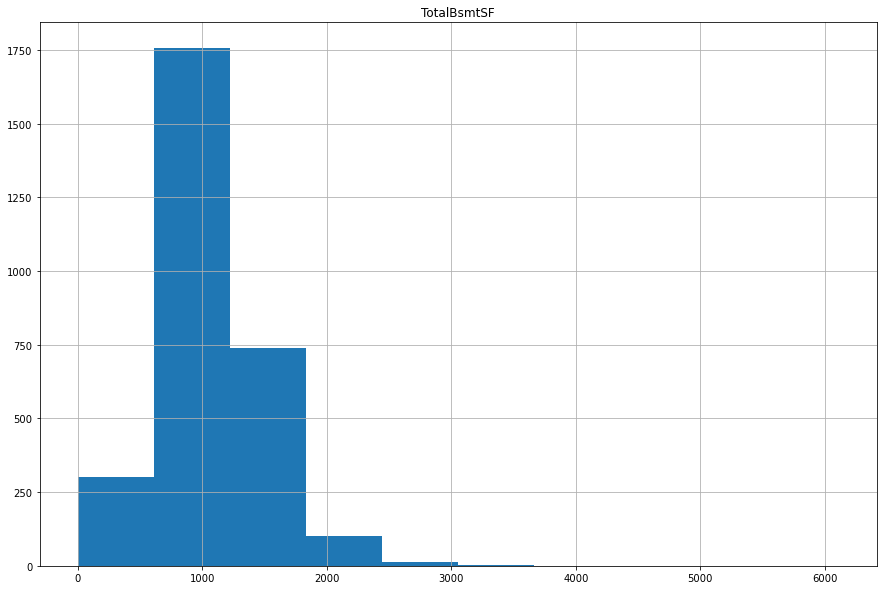

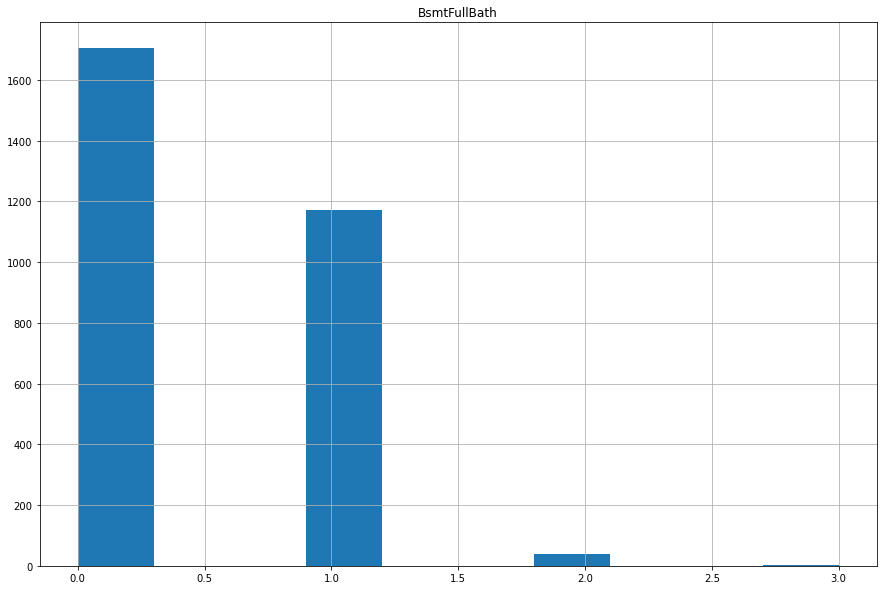

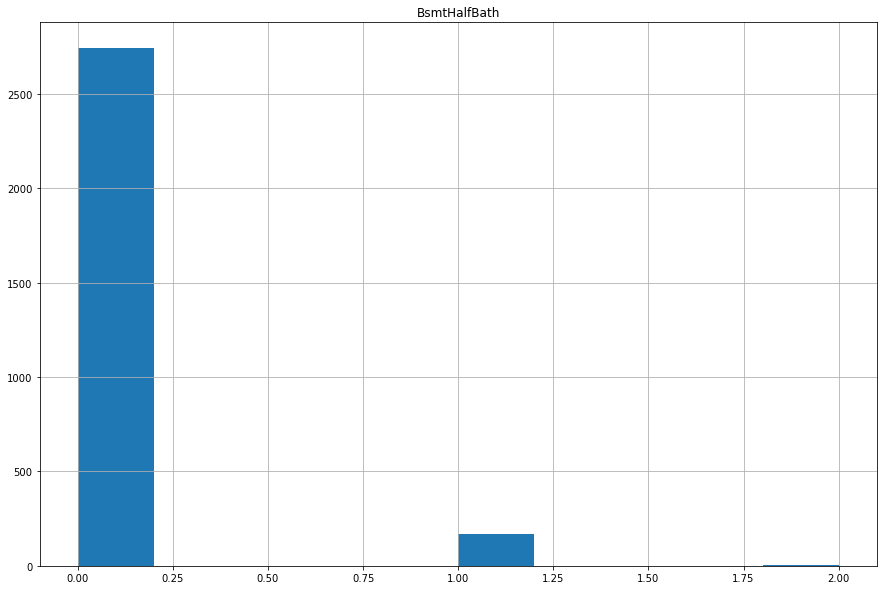

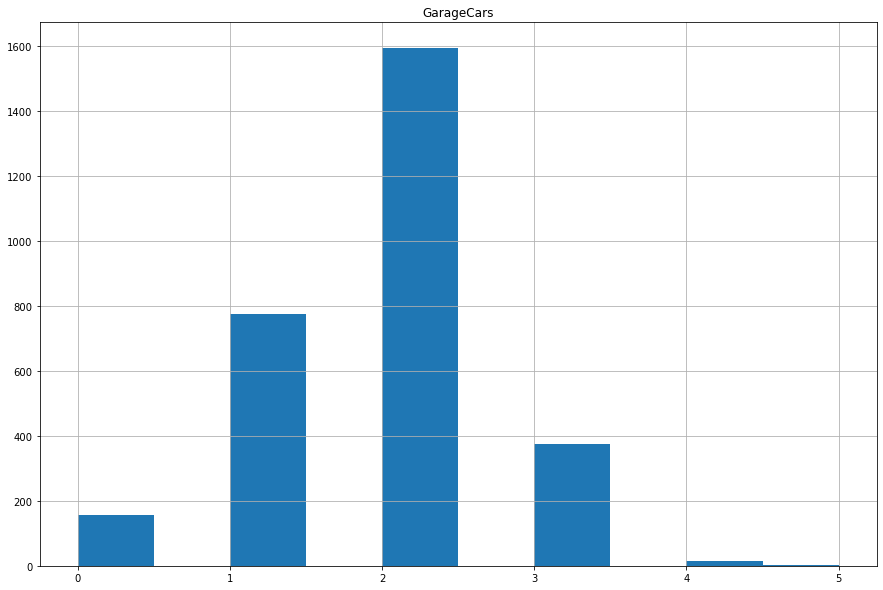

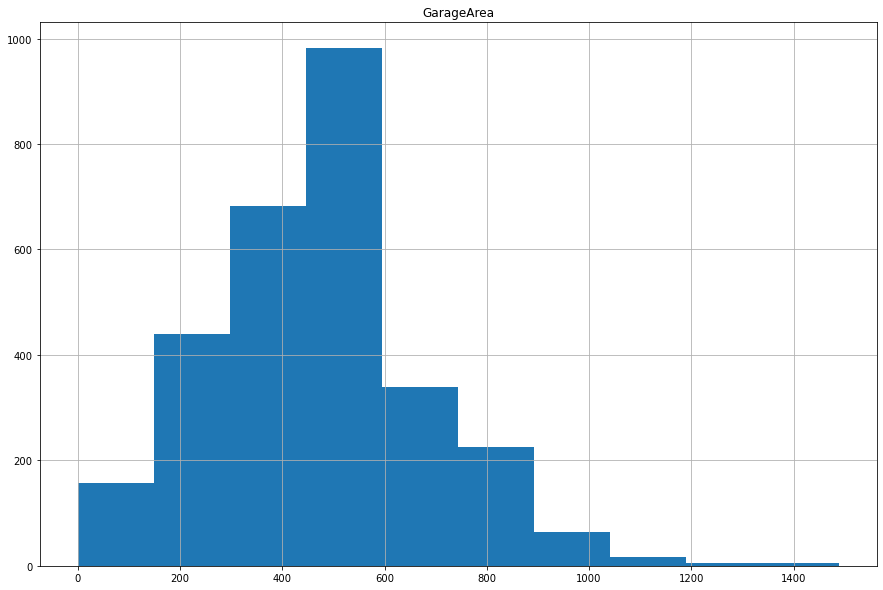

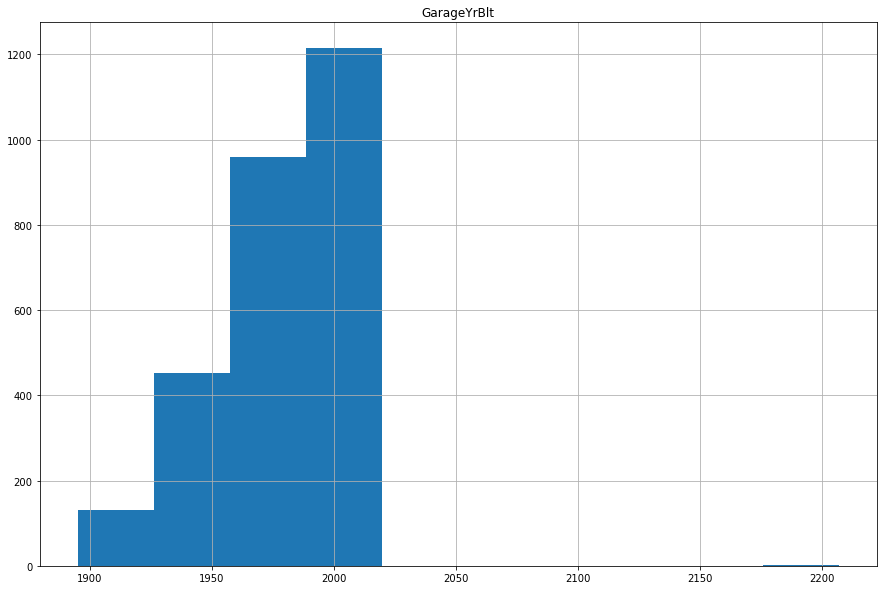

,count,mean,std,min,25%,50%,75%,max
MSSubClass,2919.0,57.137718,42.517628,20.0,20.0,50.0,70.0,190.0
EnclosedPorch,2919.0,23.098321,64.244246,0.0,0.0,0.0,0.0,1012.0
GrLivArea,2919.0,1500.759849,506.051045,334.0,1126.0,1444.0,1743.5,5642.0
PoolArea,2919.0,2.251799,35.663946,0.0,0.0,0.0,0.0,800.0
OverallQual,2919.0,6.089072,1.409947,1.0,5.0,6.0,7.0,10.0
FullBath,2919.0,1.568003,0.552969,0.0,1.0,2.0,2.0,4.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0
MoSold,2919.0,6.213087,2.714762,1.0,4.0,6.0,8.0,12.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1953.5,1973.0,2001.0,2010.0
OpenPorchSF,2919.0,47.486811,67.575493,0.0,0.0,26.0,70.0,742.0


In [25]:
describe_numerical_columns(df.select(num_cols), plot=1)

It would say that most of the numerical values have not got normal distribution. Also checking outliers is the necessary.
#### Categorical Columns

In [26]:
from _eda_utils import describe_categoric_columns

2023-04-06 05:50:11,701 - logging_utils - DEBUG - describe_categoric_columns function is executing...
2023-04-06 05:50:11,703 - logging_utils - INFO - ['MSZoning']
2023-04-06 05:50:11,812 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:11,813 - logging_utils - INFO - 
RL         2265
RM          460
FV          139
RH           26
C (all)      25
NA            4
Name: MSZoning, dtype: int64


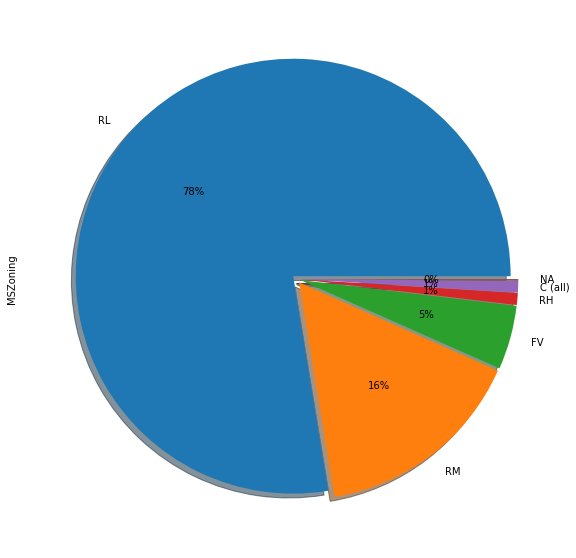

2023-04-06 05:50:11,954 - logging_utils - INFO - ['Street']
2023-04-06 05:50:12,076 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:12,078 - logging_utils - INFO - 
Pave    2907
Grvl      12
Name: Street, dtype: int64


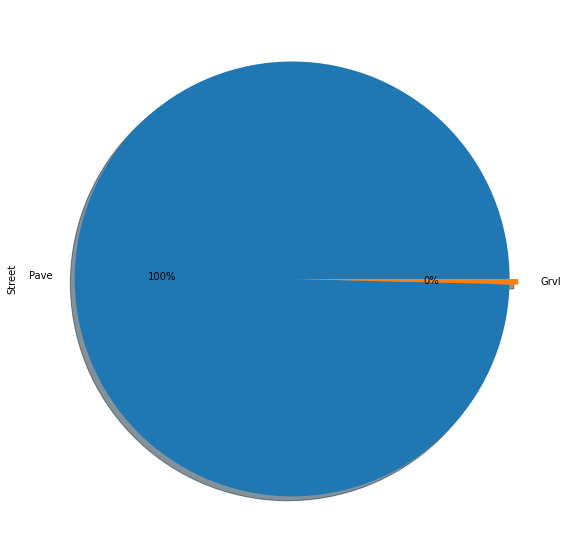

2023-04-06 05:50:12,199 - logging_utils - INFO - ['Alley']
2023-04-06 05:50:12,303 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:12,304 - logging_utils - INFO - 
NA      2721
Grvl     120
Pave      78
Name: Alley, dtype: int64


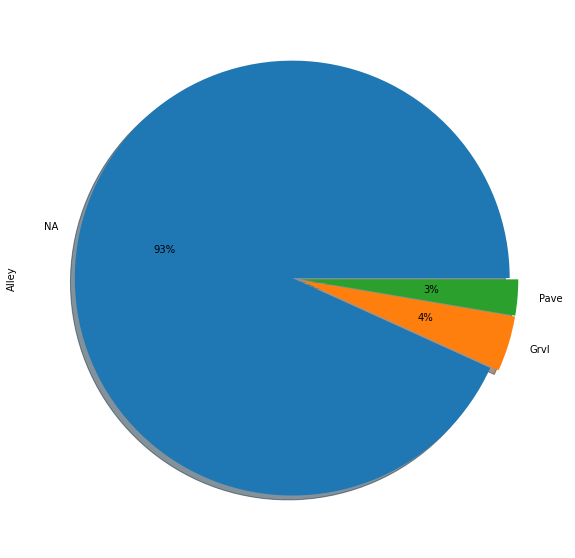

2023-04-06 05:50:12,416 - logging_utils - INFO - ['LotShape']
2023-04-06 05:50:12,524 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:12,525 - logging_utils - INFO - 
Reg    1859
IR1     968
IR2      76
IR3      16
Name: LotShape, dtype: int64


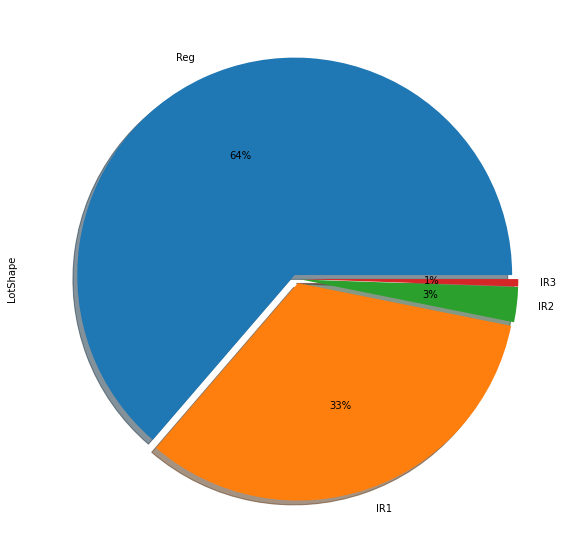

2023-04-06 05:50:12,631 - logging_utils - INFO - ['LandContour']
2023-04-06 05:50:12,728 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:12,729 - logging_utils - INFO - 
Lvl    2622
HLS     120
Bnk     117
Low      60
Name: LandContour, dtype: int64


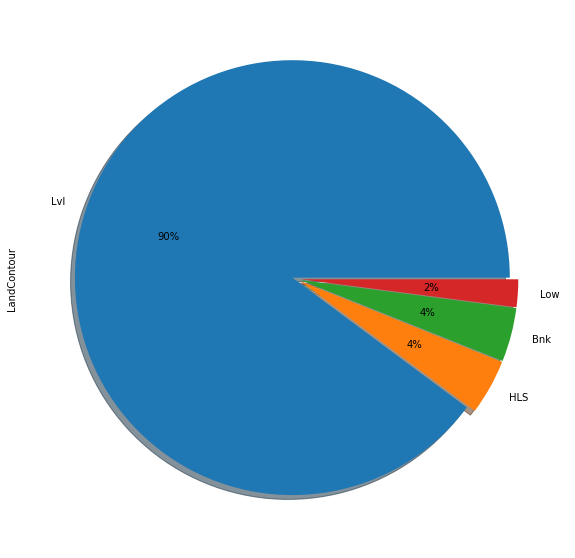

2023-04-06 05:50:12,867 - logging_utils - INFO - ['Utilities']
2023-04-06 05:50:12,963 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:12,964 - logging_utils - INFO - 
AllPub    2916
NA           2
NoSeWa       1
Name: Utilities, dtype: int64


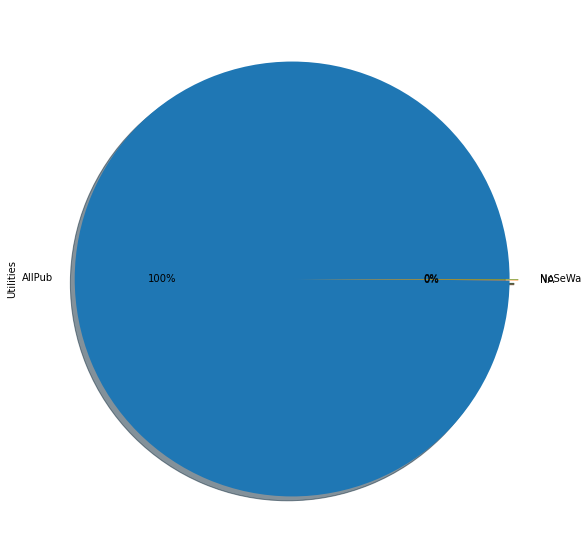

2023-04-06 05:50:13,070 - logging_utils - INFO - ['LotConfig']
2023-04-06 05:50:13,170 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:13,171 - logging_utils - INFO - 
Inside     2133
Corner      511
CulDSac     176
FR2          85
FR3          14
Name: LotConfig, dtype: int64


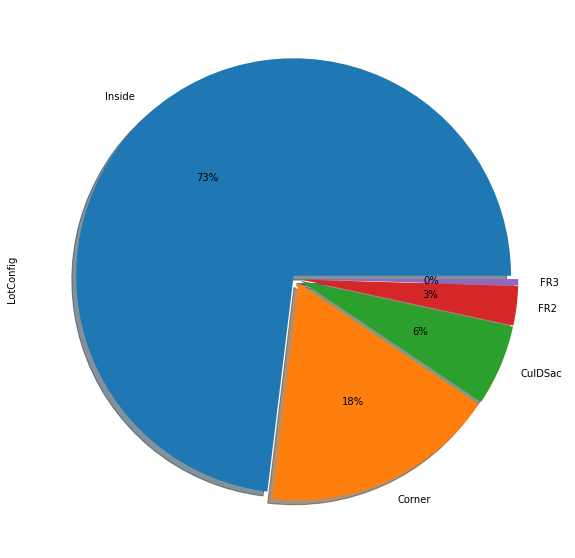

2023-04-06 05:50:13,282 - logging_utils - INFO - ['LandSlope']
2023-04-06 05:50:13,364 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:13,366 - logging_utils - INFO - 
Gtl    2778
Mod     125
Sev      16
Name: LandSlope, dtype: int64


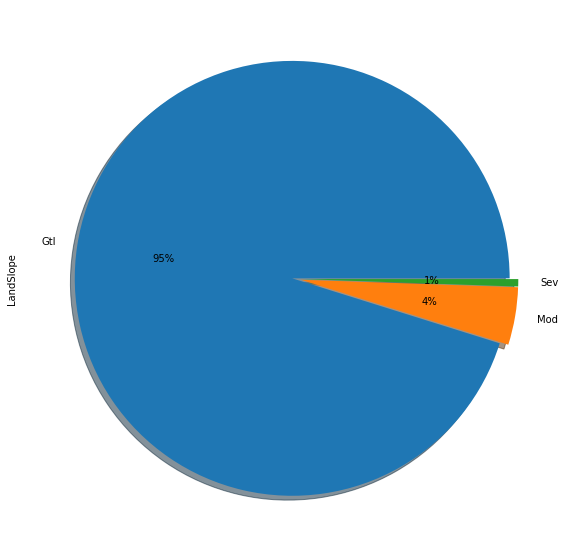

2023-04-06 05:50:13,477 - logging_utils - INFO - ['Neighborhood']
2023-04-06 05:50:13,584 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:13,585 - logging_utils - INFO - 
NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Name: Neighborhood, dtype: int64


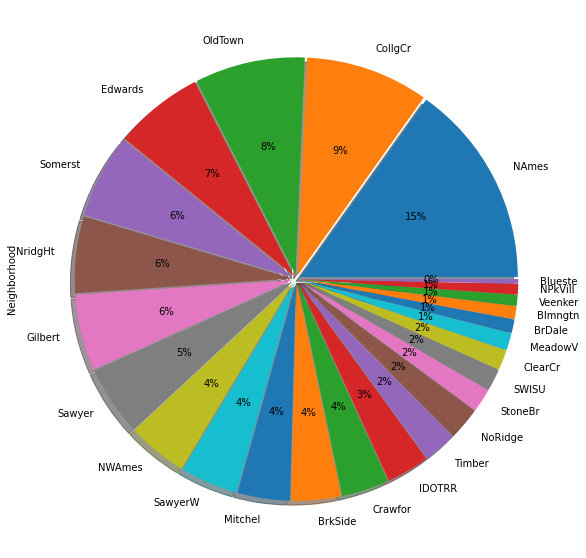

2023-04-06 05:50:13,895 - logging_utils - INFO - ['Condition1']
2023-04-06 05:50:13,997 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:13,999 - logging_utils - INFO - 
Norm      2511
Feedr      164
Artery      92
RRAn        50
PosN        39
RRAe        28
PosA        20
RRNn         9
RRNe         6
Name: Condition1, dtype: int64


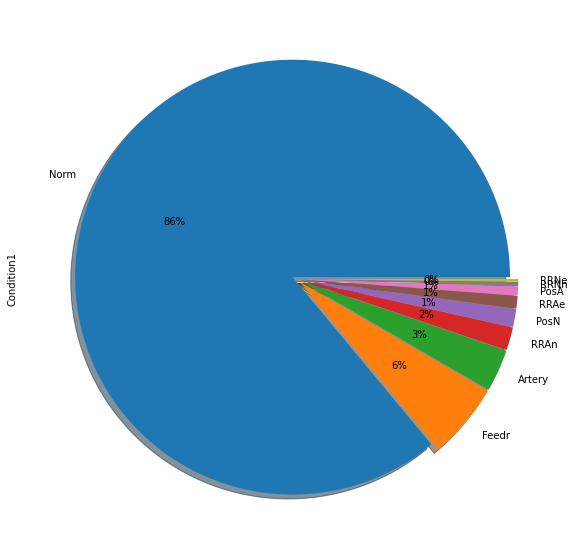

2023-04-06 05:50:14,169 - logging_utils - INFO - ['Condition2']
2023-04-06 05:50:14,254 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:14,255 - logging_utils - INFO - 
Norm      2889
Feedr       13
Artery       5
PosN         4
PosA         4
RRNn         2
RRAn         1
RRAe         1
Name: Condition2, dtype: int64


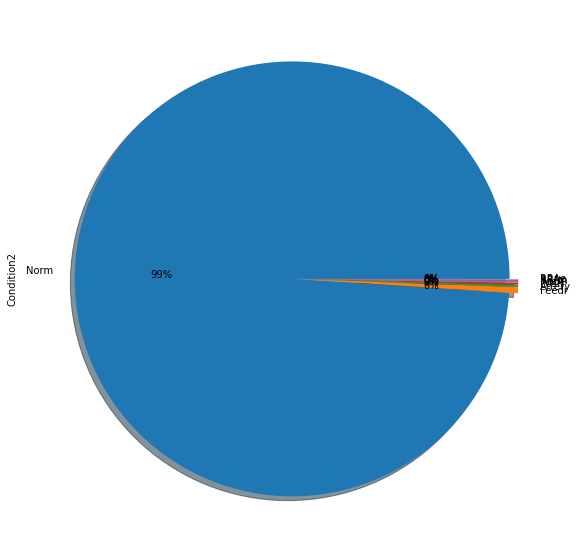

2023-04-06 05:50:14,408 - logging_utils - INFO - ['BldgType']
2023-04-06 05:50:14,494 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:14,496 - logging_utils - INFO - 
1Fam      2425
TwnhsE     227
Duplex     109
Twnhs       96
2fmCon      62
Name: BldgType, dtype: int64


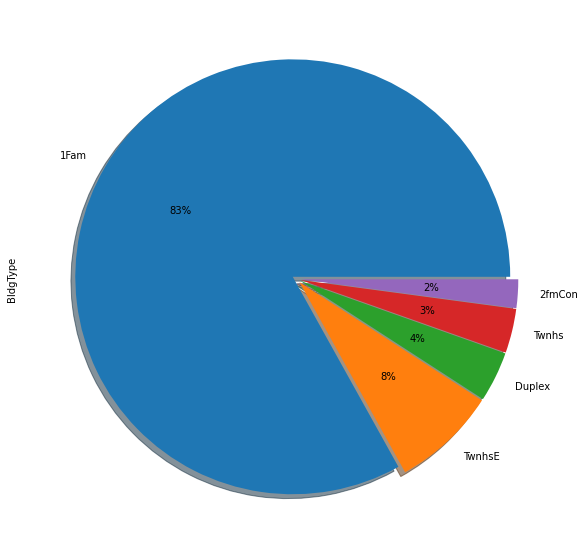

2023-04-06 05:50:14,693 - logging_utils - INFO - ['HouseStyle']
2023-04-06 05:50:14,773 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:14,774 - logging_utils - INFO - 
1Story    1471
2Story     872
1.5Fin     314
SLvl       128
SFoyer      83
2.5Unf      24
1.5Unf      19
2.5Fin       8
Name: HouseStyle, dtype: int64


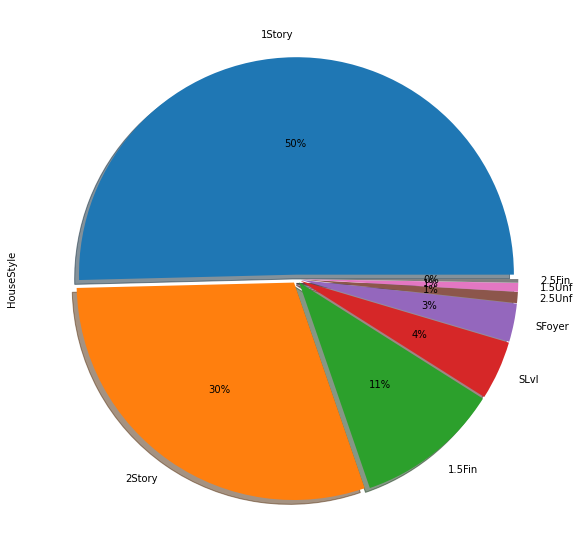

2023-04-06 05:50:14,949 - logging_utils - INFO - ['RoofStyle']
2023-04-06 05:50:15,042 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:15,045 - logging_utils - INFO - 
Gable      2310
Hip         551
Gambrel      22
Flat         20
Mansard      11
Shed          5
Name: RoofStyle, dtype: int64


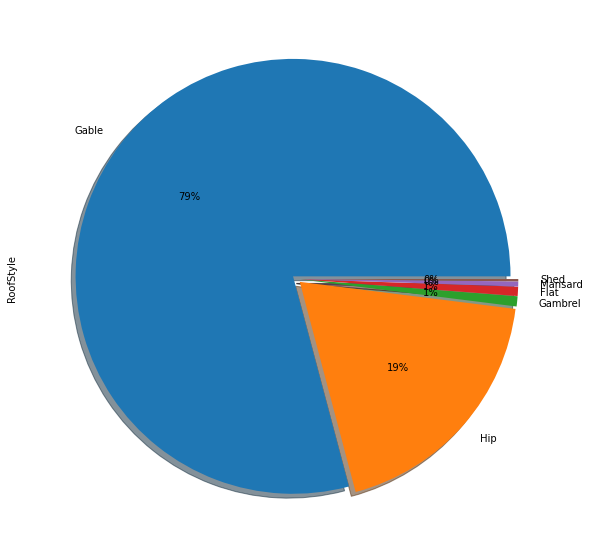

2023-04-06 05:50:15,195 - logging_utils - INFO - ['RoofMatl']
2023-04-06 05:50:15,276 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:15,277 - logging_utils - INFO - 
CompShg    2876
Tar&Grv      23
WdShake       9
WdShngl       7
Metal         1
Membran       1
Roll          1
ClyTile       1
Name: RoofMatl, dtype: int64


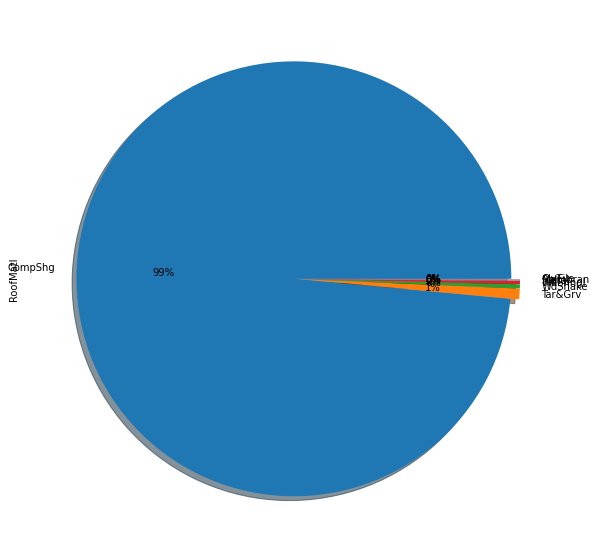

2023-04-06 05:50:15,442 - logging_utils - INFO - ['Exterior1st']
2023-04-06 05:50:15,543 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:15,545 - logging_utils - INFO - 
VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     126
BrkFace      87
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
AsphShn       2
Stone         2
CBlock        2
ImStucc       1
NA            1
Name: Exterior1st, dtype: int64


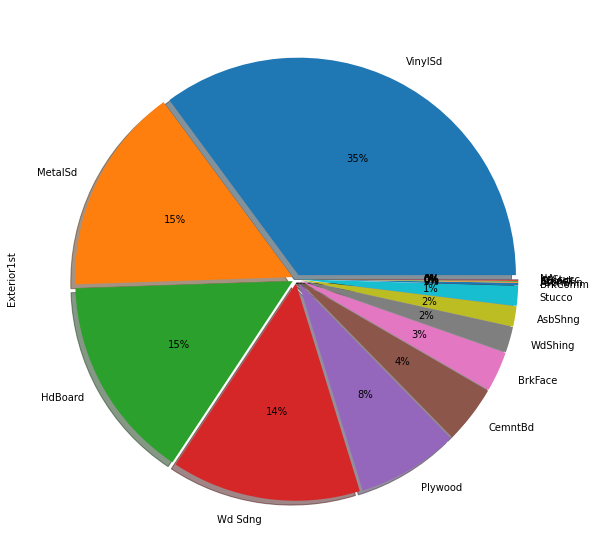

2023-04-06 05:50:15,789 - logging_utils - INFO - ['Exterior2nd']
2023-04-06 05:50:15,870 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:15,871 - logging_utils - INFO - 
VinylSd    1014
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
CmentBd     126
Wd Shng      81
Stucco       47
BrkFace      47
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone         6
AsphShn       4
CBlock        3
Other         1
NA            1
Name: Exterior2nd, dtype: int64


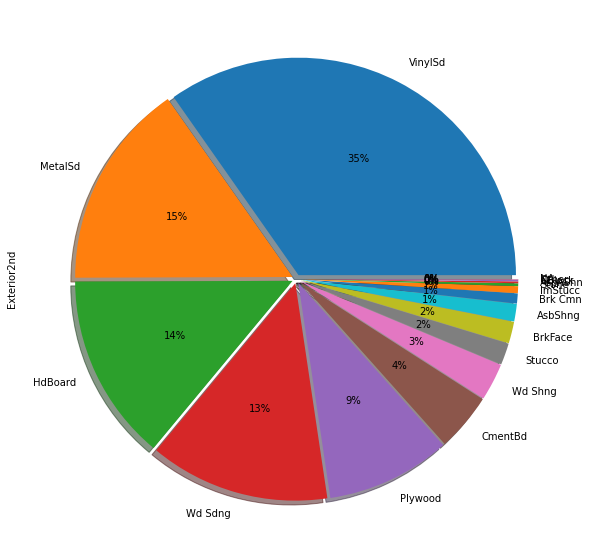

2023-04-06 05:50:16,113 - logging_utils - INFO - ['MasVnrType']
2023-04-06 05:50:16,204 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:16,205 - logging_utils - INFO - 
None       1742
BrkFace     879
Stone       249
BrkCmn       25
NA           24
Name: MasVnrType, dtype: int64


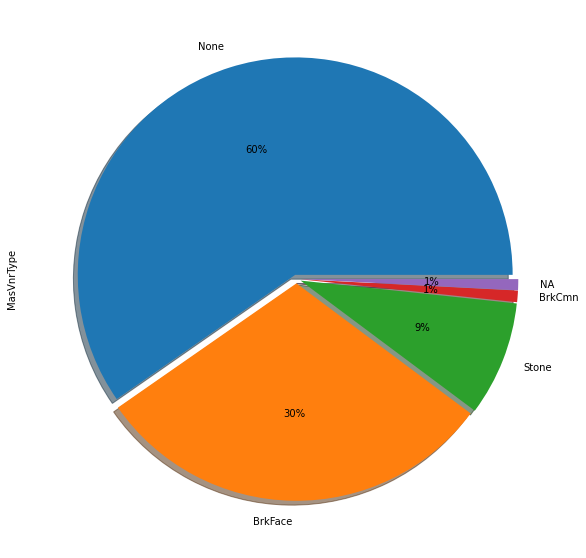

2023-04-06 05:50:16,325 - logging_utils - INFO - ['ExterQual']
2023-04-06 05:50:16,427 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:16,429 - logging_utils - INFO - 
TA    1798
Gd     979
Ex     107
Fa      35
Name: ExterQual, dtype: int64


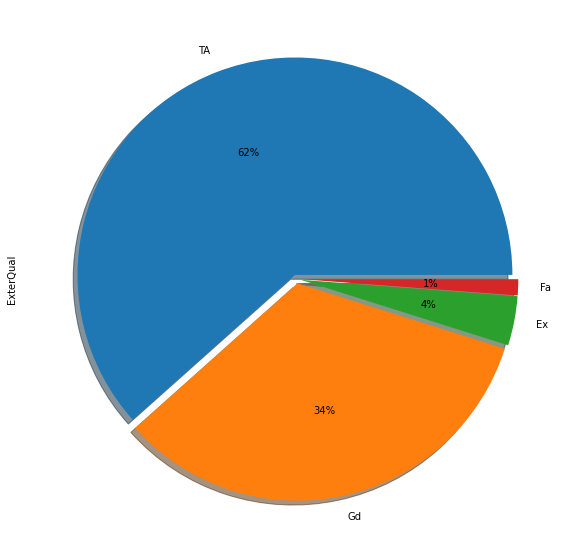

2023-04-06 05:50:16,536 - logging_utils - INFO - ['ExterCond']
2023-04-06 05:50:16,631 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:16,634 - logging_utils - INFO - 
TA    2538
Gd     299
Fa      67
Ex      12
Po       3
Name: ExterCond, dtype: int64


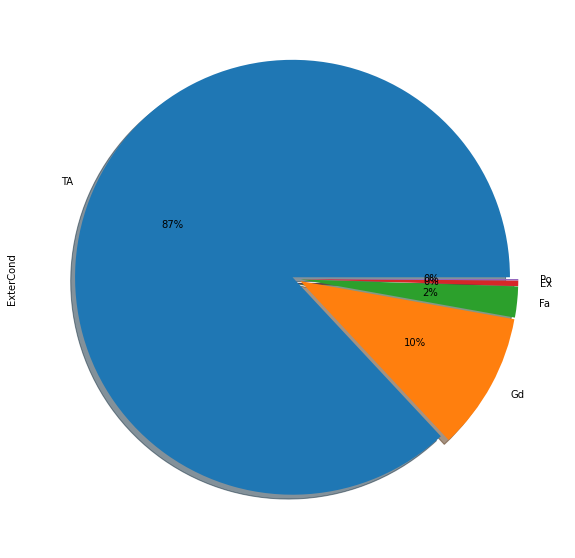

2023-04-06 05:50:16,793 - logging_utils - INFO - ['Foundation']
2023-04-06 05:50:16,875 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:16,877 - logging_utils - INFO - 
PConc     1308
CBlock    1235
BrkTil     311
Slab        49
Stone       11
Wood         5
Name: Foundation, dtype: int64


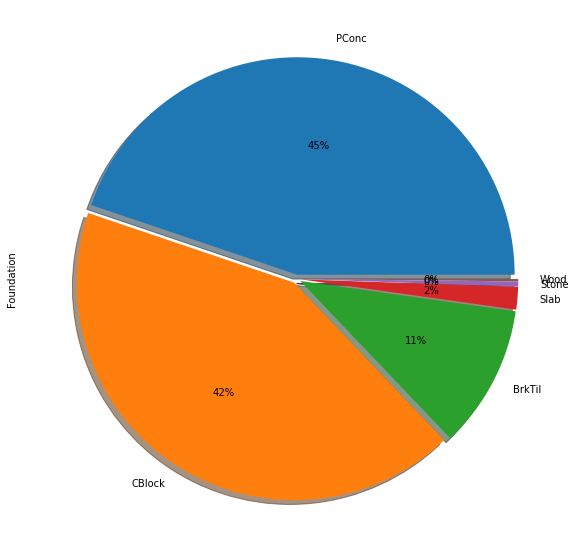

2023-04-06 05:50:17,005 - logging_utils - INFO - ['BsmtQual']
2023-04-06 05:50:17,091 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:17,093 - logging_utils - INFO - 
TA    1283
Gd    1209
Ex     258
Fa      88
NA      81
Name: BsmtQual, dtype: int64


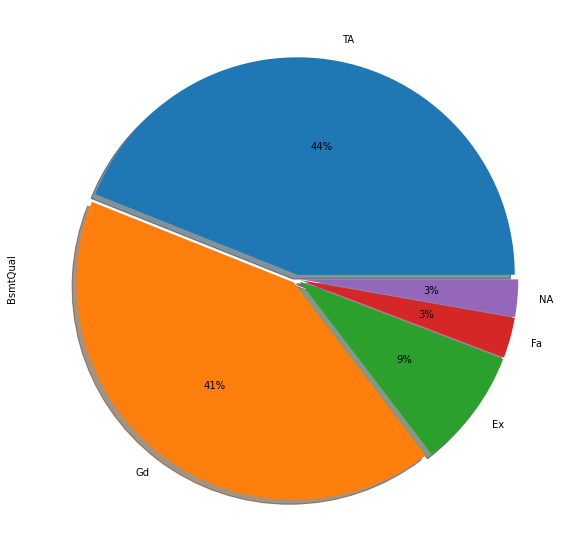

2023-04-06 05:50:17,203 - logging_utils - INFO - ['BsmtCond']
2023-04-06 05:50:17,280 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:17,282 - logging_utils - INFO - 
TA    2606
Gd     122
Fa     104
NA      82
Po       5
Name: BsmtCond, dtype: int64


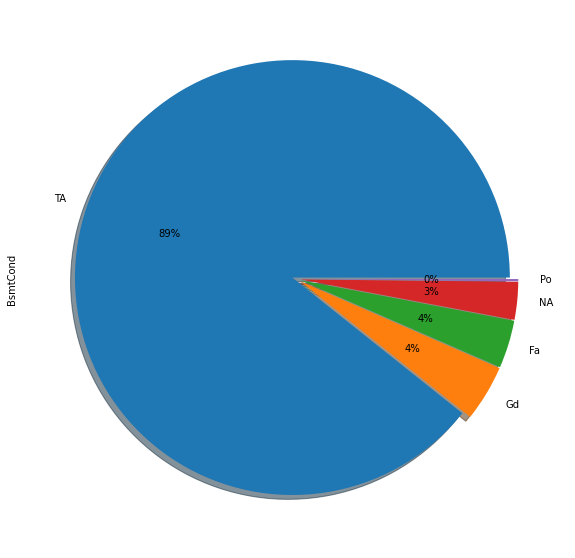

2023-04-06 05:50:17,409 - logging_utils - INFO - ['BsmtExposure']
2023-04-06 05:50:17,505 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:17,507 - logging_utils - INFO - 
No    1904
Av     418
Gd     276
Mn     239
NA      82
Name: BsmtExposure, dtype: int64


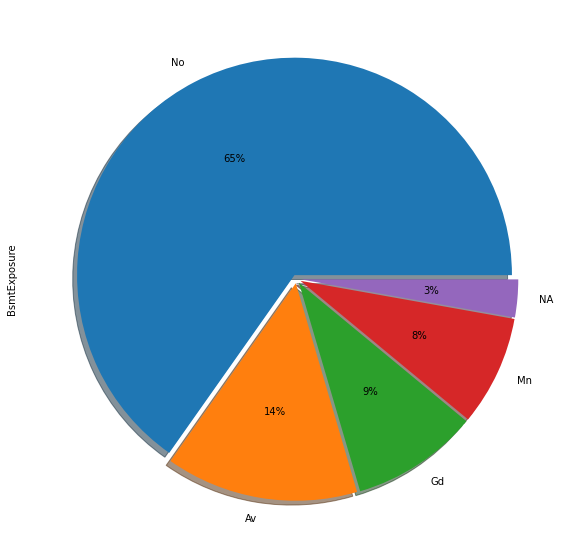

2023-04-06 05:50:17,622 - logging_utils - INFO - ['BsmtFinType1']
2023-04-06 05:50:17,701 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:17,703 - logging_utils - INFO - 
Unf    851
GLQ    849
ALQ    429
Rec    288
BLQ    269
LwQ    154
NA      79
Name: BsmtFinType1, dtype: int64


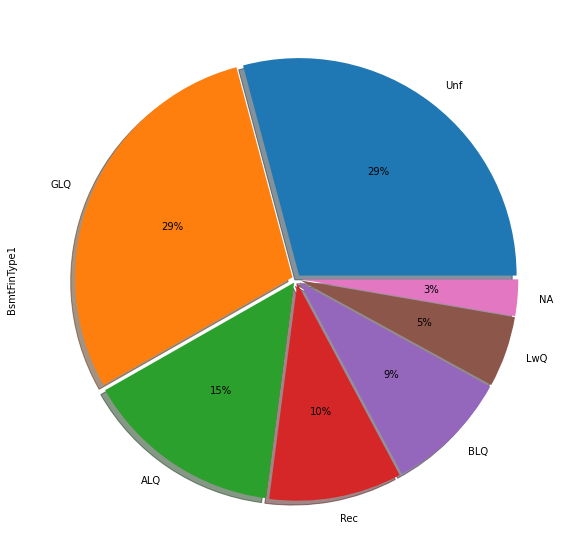

2023-04-06 05:50:17,943 - logging_utils - INFO - ['BsmtFinType2']
2023-04-06 05:50:18,239 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:18,241 - logging_utils - INFO - 
Unf    2493
Rec     105
LwQ      87
NA       80
BLQ      68
ALQ      52
GLQ      34
Name: BsmtFinType2, dtype: int64


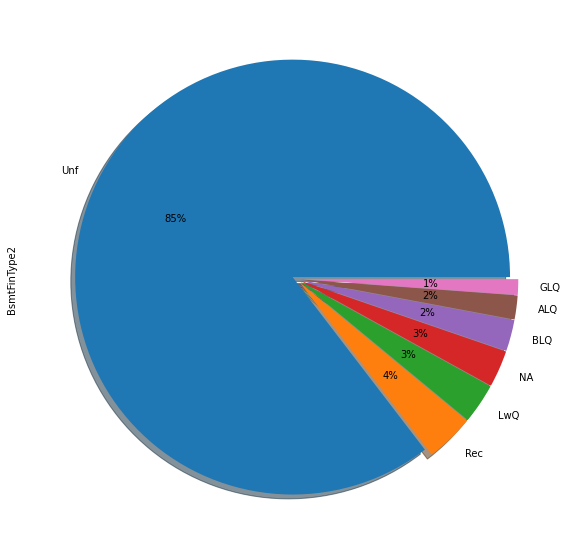

2023-04-06 05:50:18,413 - logging_utils - INFO - ['Heating']
2023-04-06 05:50:18,493 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:18,494 - logging_utils - INFO - 
GasA     2874
GasW       27
Grav        9
Wall        6
OthW        2
Floor       1
Name: Heating, dtype: int64


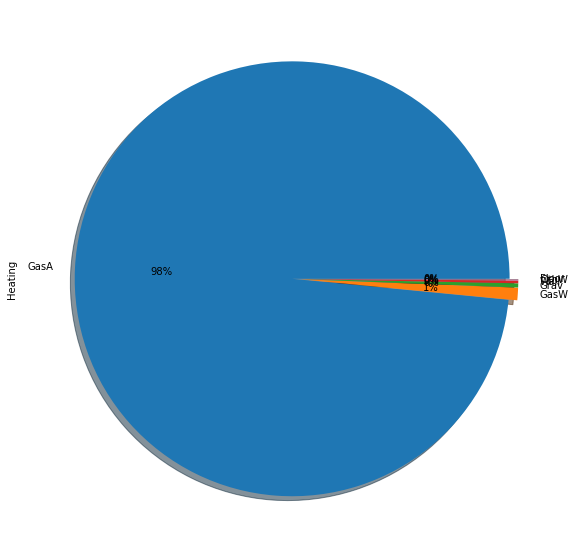

2023-04-06 05:50:18,639 - logging_utils - INFO - ['HeatingQC']
2023-04-06 05:50:18,797 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:18,802 - logging_utils - INFO - 
Ex    1493
TA     857
Gd     474
Fa      92
Po       3
Name: HeatingQC, dtype: int64


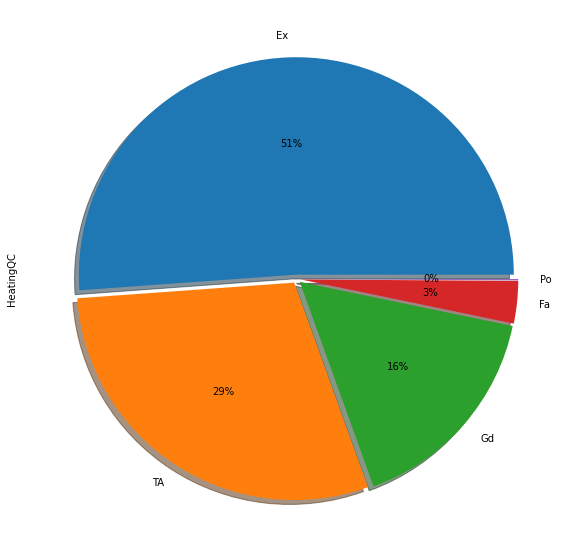

2023-04-06 05:50:19,059 - logging_utils - INFO - ['CentralAir']
2023-04-06 05:50:19,165 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:19,167 - logging_utils - INFO - 
Y    2723
N     196
Name: CentralAir, dtype: int64


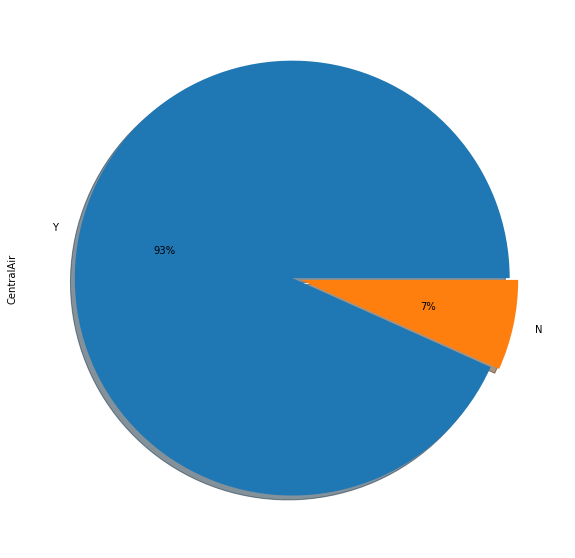

2023-04-06 05:50:19,295 - logging_utils - INFO - ['Electrical']
2023-04-06 05:50:19,395 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:19,397 - logging_utils - INFO - 
SBrkr    2671
FuseA     188
FuseF      50
FuseP       8
Mix         1
NA          1
Name: Electrical, dtype: int64


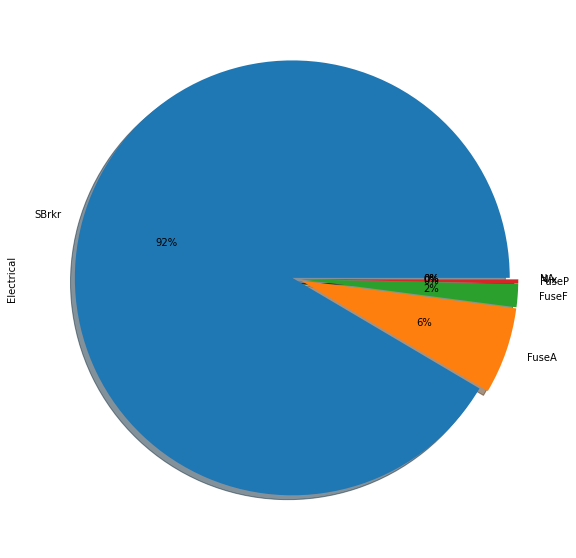

2023-04-06 05:50:19,604 - logging_utils - INFO - ['KitchenQual']
2023-04-06 05:50:19,737 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:19,742 - logging_utils - INFO - 
TA    1492
Gd    1151
Ex     205
Fa      70
NA       1
Name: KitchenQual, dtype: int64


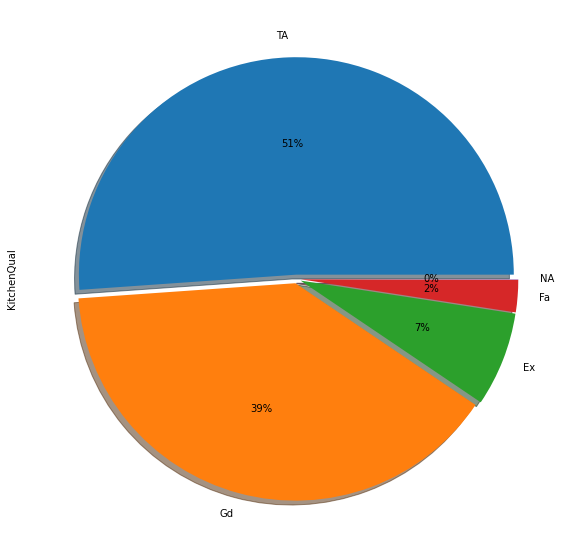

2023-04-06 05:50:19,911 - logging_utils - INFO - ['Functional']
2023-04-06 05:50:20,012 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:20,014 - logging_utils - INFO - 
Typ     2717
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
NA         2
Name: Functional, dtype: int64


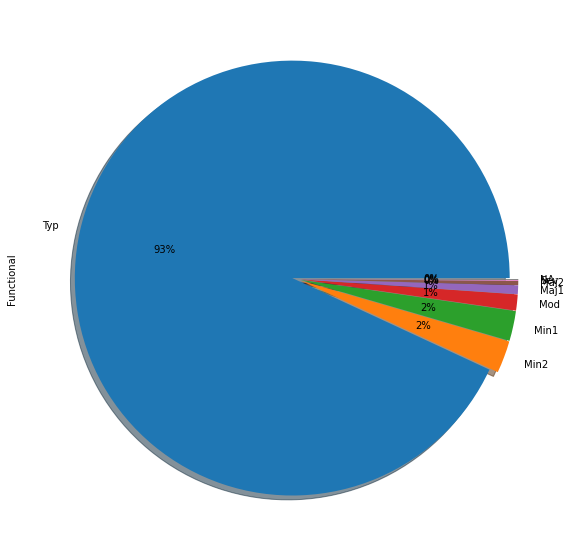

2023-04-06 05:50:20,201 - logging_utils - INFO - ['FireplaceQu']
2023-04-06 05:50:20,285 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:20,286 - logging_utils - INFO - 
NA    1420
Gd     744
TA     592
Fa      74
Po      46
Ex      43
Name: FireplaceQu, dtype: int64


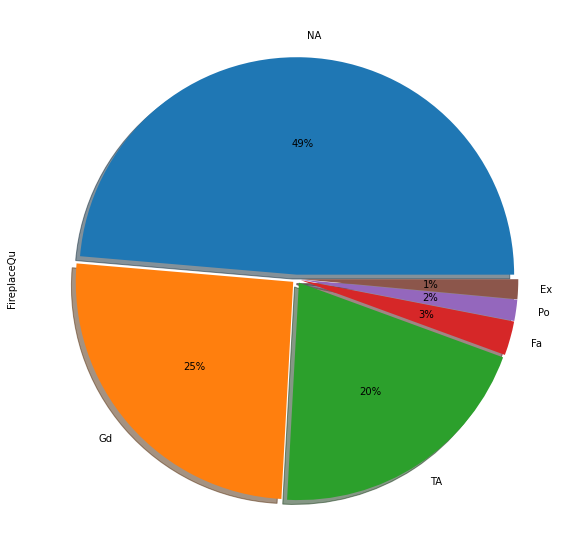

2023-04-06 05:50:20,409 - logging_utils - INFO - ['GarageType']
2023-04-06 05:50:20,513 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:20,514 - logging_utils - INFO - 
Attchd     1723
Detchd      779
BuiltIn     186
NA          157
Basment      36
2Types       23
CarPort      15
Name: GarageType, dtype: int64


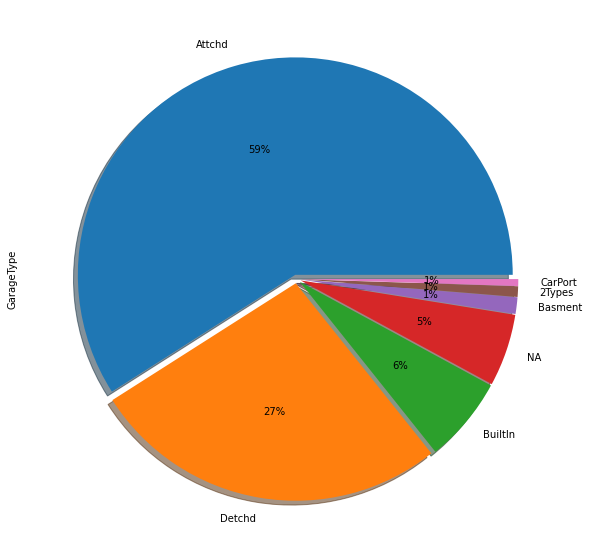

2023-04-06 05:50:20,715 - logging_utils - INFO - ['GarageFinish']
2023-04-06 05:50:20,820 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:20,822 - logging_utils - INFO - 
Unf    1230
RFn     811
Fin     719
NA      159
Name: GarageFinish, dtype: int64


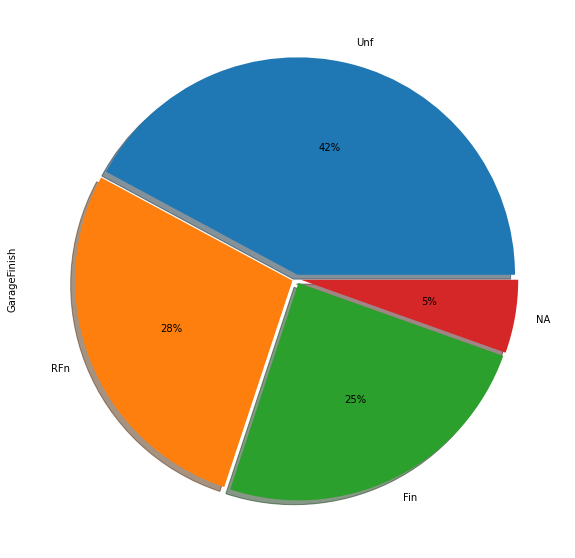

2023-04-06 05:50:20,944 - logging_utils - INFO - ['GarageQual']
2023-04-06 05:50:21,046 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:21,048 - logging_utils - INFO - 
TA    2604
NA     159
Fa     124
Gd      24
Po       5
Ex       3
Name: GarageQual, dtype: int64


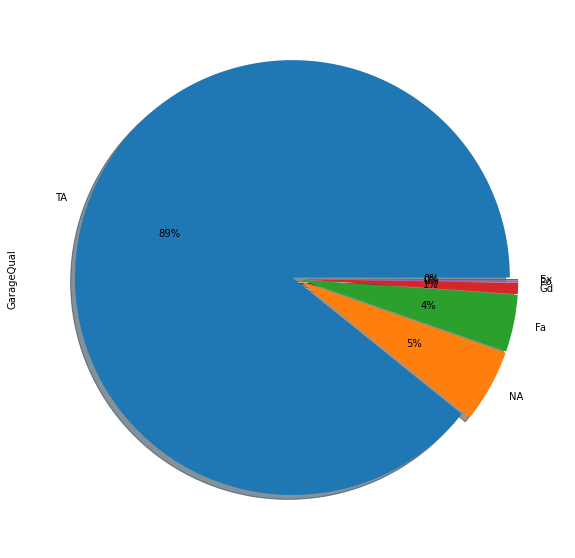

2023-04-06 05:50:21,240 - logging_utils - INFO - ['GarageCond']
2023-04-06 05:50:21,363 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:21,364 - logging_utils - INFO - 
TA    2654
NA     159
Fa      74
Gd      15
Po      14
Ex       3
Name: GarageCond, dtype: int64


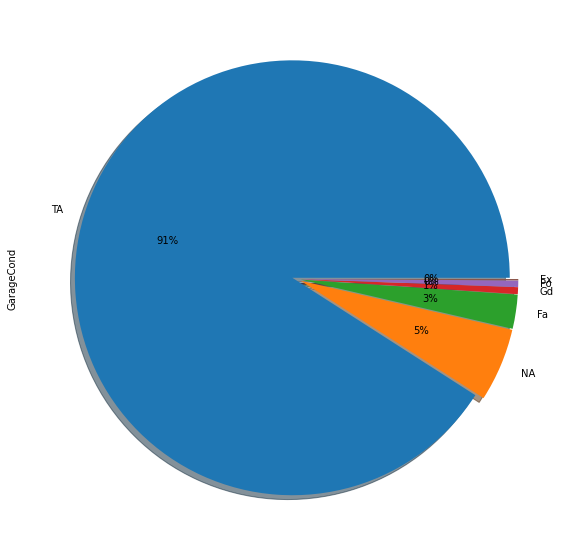

2023-04-06 05:50:21,531 - logging_utils - INFO - ['PavedDrive']
2023-04-06 05:50:21,620 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:21,622 - logging_utils - INFO - 
Y    2641
N     216
P      62
Name: PavedDrive, dtype: int64


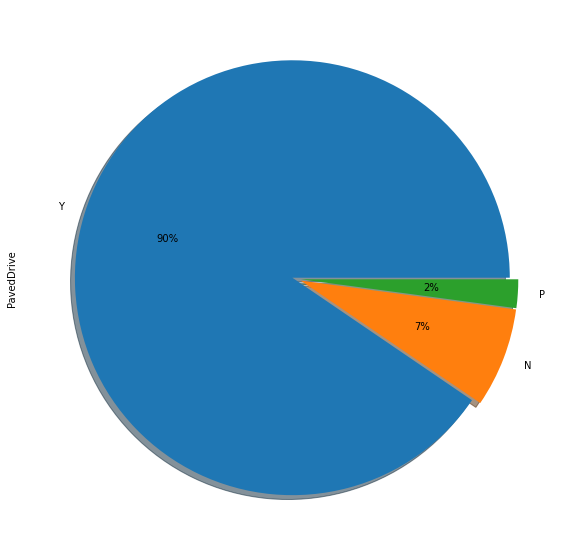

2023-04-06 05:50:21,754 - logging_utils - INFO - ['PoolQC']
2023-04-06 05:50:21,862 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:21,864 - logging_utils - INFO - 
NA    2909
Ex       4
Gd       4
Fa       2
Name: PoolQC, dtype: int64


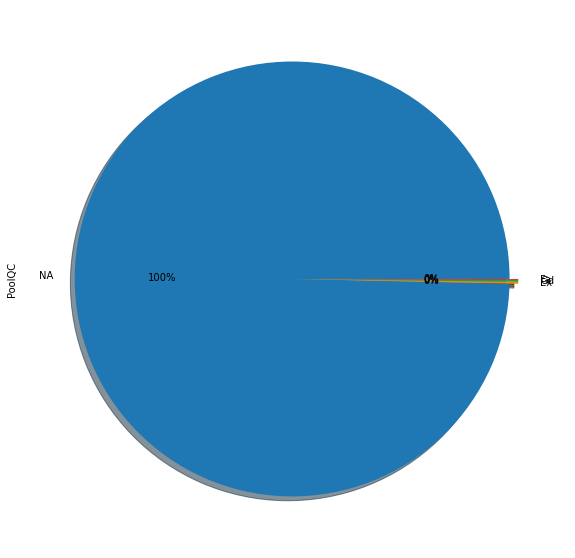

2023-04-06 05:50:21,985 - logging_utils - INFO - ['Fence']
2023-04-06 05:50:22,093 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:22,095 - logging_utils - INFO - 
NA       2348
MnPrv     329
GdPrv     118
GdWo      112
MnWw       12
Name: Fence, dtype: int64


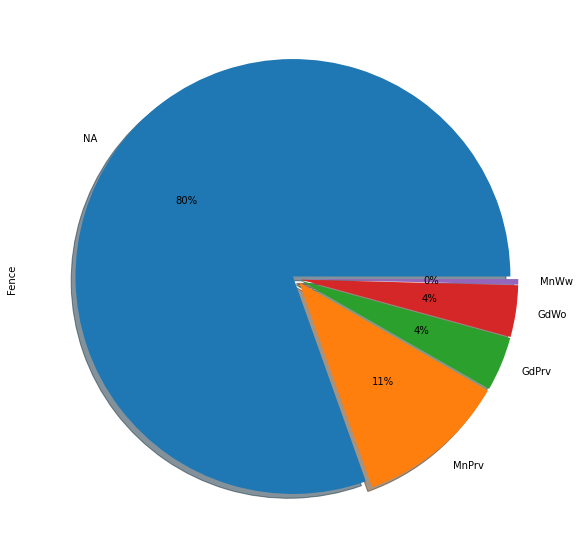

2023-04-06 05:50:22,265 - logging_utils - INFO - ['MiscFeature']
2023-04-06 05:50:22,358 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:22,359 - logging_utils - INFO - 
NA      2814
Shed      95
Gar2       5
Othr       4
TenC       1
Name: MiscFeature, dtype: int64


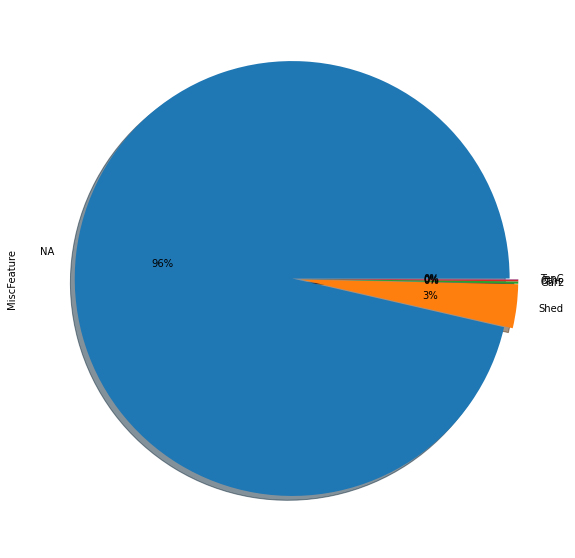

2023-04-06 05:50:22,498 - logging_utils - INFO - ['SaleType']
2023-04-06 05:50:22,638 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:22,640 - logging_utils - INFO - 
WD       2525
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
NA          1
Name: SaleType, dtype: int64


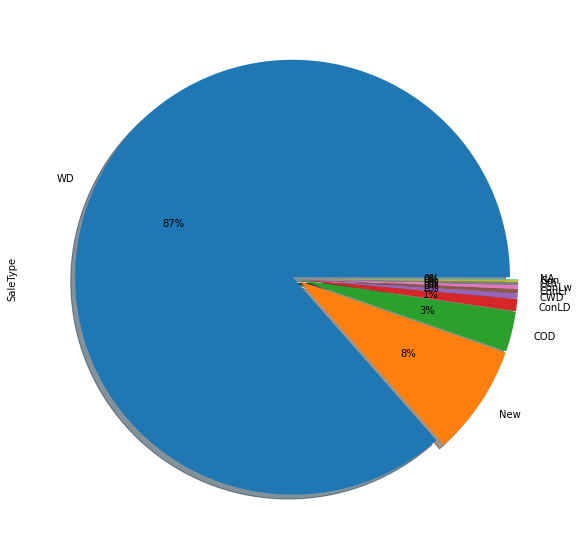

2023-04-06 05:50:22,825 - logging_utils - INFO - ['SaleCondition']
2023-04-06 05:50:22,915 - logging_utils - DEBUG - describe_categoric executing...
2023-04-06 05:50:22,917 - logging_utils - INFO - 
Normal     2402
Partial     245
Abnorml     190
Family       46
Alloca       24
AdjLand      12
Name: SaleCondition, dtype: int64


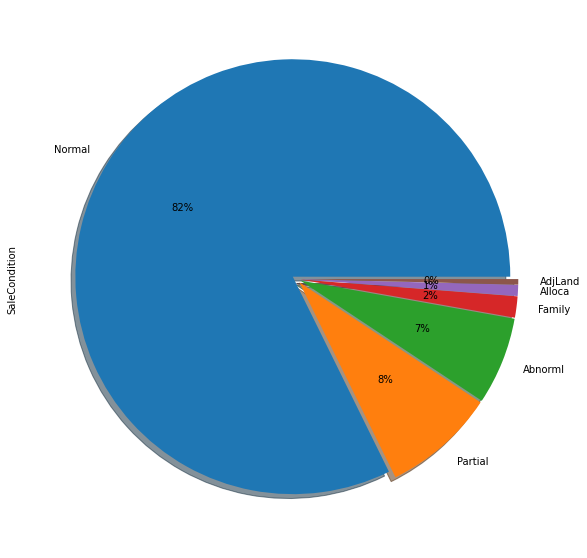

In [27]:
describe_categoric_columns(df.select(cat_cols))

Result is the categoric columns have got too rare features. Should to analyze rare features one by one. After analysis, merge rare features to each other.
#### Describing Columns for Target

In [28]:
from _eda_utils import describe_columns_to_target

In [29]:
describe_columns_to_target(df, cat_cols, 'SalePrice')

2023-04-06 05:50:23,223 - logging_utils - DEBUG - describe_columns_to_target executing...
+--------+------------------+------+------------------+
|MSZoning|Mean              |Median|Std               |
+--------+------------------+------+------------------+
|C (all) |74528.0           |68400 |33791.092031283435|
|RM      |126316.83027522935|120500|48521.68983254896 |
|RL      |191004.99478714162|174000|80766.3413193025  |
|RH      |131558.375        |133000|35714.11843491777 |
|FV      |214014.06153846154|205950|52369.66206744754 |
|NA      |null              |null  |null              |
+--------+------------------+------+------------------+

+------+------------------+------+-----------------+
|Street|Mean              |Median|Std              |
+------+------------------+------+-----------------+
|Pave  |181130.53851444292|163000|79446.59731743201|
|Grvl  |130190.5          |110000|65446.25399134774|
+------+------------------+------+-----------------+

+-----+------------------+----

Can analyze categorical columns for target columns.

### Checking Missing and Outliers

#### Missing Values

In [101]:
from _eda_utils import check_missing_values

In [31]:
check_missing_values(df)

2023-04-06 05:50:31,081 - logging_utils - DEBUG - check_missing_values executing...
2023-04-06 05:50:31,809 - logging_utils - INFO - MSZoning has 4 -  0.14 % null count.
2023-04-06 05:50:32,009 - logging_utils - INFO - LotFrontage has 486 -  16.65 % null count.
2023-04-06 05:50:32,536 - logging_utils - INFO - Alley has 2721 -  93.22 % null count.
2023-04-06 05:50:33,060 - logging_utils - INFO - Utilities has 2 -  0.07 % null count.
2023-04-06 05:50:35,588 - logging_utils - INFO - Exterior1st has 1 -  0.03 % null count.
2023-04-06 05:50:35,791 - logging_utils - INFO - Exterior2nd has 1 -  0.03 % null count.
2023-04-06 05:50:35,974 - logging_utils - INFO - MasVnrType has 24 -  0.82 % null count.
2023-04-06 05:50:36,146 - logging_utils - INFO - MasVnrArea has 23 -  0.79 % null count.
2023-04-06 05:50:36,902 - logging_utils - INFO - BsmtQual has 81 -  2.77 % null count.
2023-04-06 05:50:37,073 - logging_utils - INFO - BsmtCond has 82 -  2.81 % null count.
2023-04-06 05:50:37,257 - logging_

Some columns are nearly empty therefore it can be drop from dataframe.

In [32]:
drop_cols = ['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu']

df = df.drop(*drop_cols)

In [102]:
check_missing_values(df, save=1)

2023-04-06 06:52:38,515 - logging_utils - DEBUG - check_missing_values executing...
2023-04-06 06:52:39,041 - logging_utils - INFO - MSZoning has 4 -  0.14 % null count.
2023-04-06 06:52:39,209 - logging_utils - INFO - LotFrontage has 486 -  16.65 % null count.
2023-04-06 06:52:40,025 - logging_utils - INFO - Utilities has 2 -  0.07 % null count.
2023-04-06 06:52:42,121 - logging_utils - INFO - Exterior1st has 1 -  0.03 % null count.
2023-04-06 06:52:42,272 - logging_utils - INFO - Exterior2nd has 1 -  0.03 % null count.
2023-04-06 06:52:42,449 - logging_utils - INFO - MasVnrType has 24 -  0.82 % null count.
2023-04-06 06:52:42,619 - logging_utils - INFO - MasVnrArea has 23 -  0.79 % null count.
2023-04-06 06:52:43,242 - logging_utils - INFO - BsmtQual has 81 -  2.77 % null count.
2023-04-06 06:52:43,412 - logging_utils - INFO - BsmtCond has 82 -  2.81 % null count.
2023-04-06 06:52:43,572 - logging_utils - INFO - BsmtExposure has 82 -  2.81 % null count.
2023-04-06 06:52:43,723 - logg

#### Outliers

In [103]:
from _eda_utils import check_outlier_values

In [104]:
check_outlier_values(df, num_cols, save=1)

2023-04-06 06:54:08,317 - logging_utils - DEBUG - check_outlier_values executing...
2023-04-06 06:54:08,479 - logging_utils - INFO - EnclosedPorch has 1 - %  0.03 outliers count.
2023-04-06 06:54:08,652 - logging_utils - INFO - PoolArea has 13 - %  0.45 outliers count.
2023-04-06 06:54:08,901 - logging_utils - INFO - LotArea has 4 - %  0.14 outliers count.
2023-04-06 06:54:09,203 - logging_utils - INFO - OpenPorchSF has 1 - %  0.03 outliers count.
2023-04-06 06:54:09,292 - logging_utils - INFO - 1stFlrSF has 1 - %  0.03 outliers count.
2023-04-06 06:54:09,540 - logging_utils - INFO - LowQualFinSF has 18 - %  0.62 outliers count.
2023-04-06 06:54:09,760 - logging_utils - INFO - WoodDeckSF has 1 - %  0.03 outliers count.
2023-04-06 06:54:09,996 - logging_utils - INFO - MiscVal has 12 - %  0.41 outliers count.
2023-04-06 06:54:10,404 - logging_utils - INFO - 3SsnPorch has 2 - %  0.07 outliers count.


## Final
Dataset is the so complex. It have to handle outliers, missing, values and rare features. **EDA** is already finished. Final operation is the dropping the *id column*. After these save the final dataframe as parquet.

In [107]:
df = df.drop("Id")

In [113]:
path = "file:///Users/talha/OneDrive/Masaüstü/Talha Nebi Kumru/Data Science/Miuul/Machine Learning/House_Price_Prediction/datasets/eda/output/house.parquet"
df.write \
    .parquet(path)

In [111]:
num_cols = [col for col in num_cols if col != "Id"]

In [114]:
import pickle

In [115]:
with open("numerical_columns", "wb") as file:
    pickle.dump(num_cols, file)

In [116]:
with open("categorical_columns", "wb") as file:
    pickle.dump(cat_cols, file)

In [119]:
spark.stop()